# Temporal Performance Evaluation on Collaborative Filtering Algorithms
>Author: Miftahul Ridwan

>Email: m.ridwan@tilburguniversity.edu

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 1. Data Preparation
The dataset we are using is downloaded from https://www.kaggle.com/netflix-inc/netflix-prize-data. In this thesis, we are only using the training data, which comes in 4 text file. In each file, the first line contains the movie id followed by a colon and then CustomerID, Rating, and Date. Before we use this data, we have to prepare them in a way that the algorithms will understand them.

The steps we are taken in this preprocessing are:
1. Reshape the data, so that it is in [user_id, rating, date, movie_id] format
2. Convert date column into datetime format
3. Save the preprocessed dataset into a new file, so we do not have to preprocess it over again everytime we want to work on this thesis.
4. Add "day_name" column to a new dataset for visualization purpose.

The output file was saved in feather format, allowing to preserve all of the formating while maintaining relatively efficient computing power and storage capacity. For output format comparison, please refer to: https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d

In [0]:
import pandas as pd
from collections import deque

### -------------   Define a function to preprocess the data   ------------- ###
def extract_and_arrage(df):
  # Read the data
  df = pd.read_csv(df, header = None, names = ["user_id", "rating", "date"],
                   usecols = [0,1,2])
  
  # After we load the data, movie_id would be sitting in the user_id column, but
  # without date and rating information in that row. Thus we lookup for the row
  # that has no date and rating information and save the index of the movie_id
  tmp_movies = df[df['rating'].isna()]['user_id'].reset_index()
  movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

  # Shift the movie_indices by one to get start and end indexes of all movies
  shifted_movie_indices = deque(movie_indices)
  shifted_movie_indices.rotate(-1)

  # Gather all dataframes
  user_data = []

  # Iterate over all movies
  for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    # Check if it is the last movie in the file
    if df_id_1<df_id_2:
      tmp_df = df.iloc[df_id_1+1:df_id_2-1].copy()
    else:
      tmp_df = df.iloc[df_id_1+1:].copy()   
    # Create movie_id column
    tmp_df['movie_id'] = movie_id
    # Append dataframe to list
    user_data.append(tmp_df)

  # Combine all dataframes
  df = pd.concat(user_data)
  df['date'] = pd.to_datetime(df['date'])
  return df

In [0]:
### ------------------------------------------------------------------------ ###
### -------------------   !!! HEAVY PROCESS AHEAD !!!   -------------------- ###
### ----------------------   Proceed with cautions   ----------------------- ###
### ------------------------------------------------------------------------ ###


### -----------------------   Process the dataset   ------------------------ ###
wd = '/content/drive/My Drive/Master Thesis - Clean/Dataset/' # dataset Directory
frames = []
for i in range(4):
  frames.append(extract_and_arrage(wd+'combined_data_{}.txt'.format(i+1)))

### -------   Concatenate the processed data into single dataframe   ------- ###
df = pd.concat(frames, ignore_index=True, sort=False)
df = pd.DataFrame(df)
df = df.reset_index(drop=True)

### ----------   Create a new dataset for visualization purpose   ---------- ###
visualize_df = df
visualize_df['day_name'] = visualize_df['date'].dt.strftime('%A')

Save concatenated file, so we do not need to redo data processing everytime

In [0]:
df.to_feather(wd+'df_concat.feather')
visualize_df.to_feather(wd+'visualize_df.feather')

#2. Exploratory Data Analysis

Before we deploy our algorithm, it is always a good idea to first understand the data. In this sense, we would do simple summary statistics and data visualization regarding movies, users, and rating distribution.

In [0]:
### ---------------   Load necessary library and settings   ---------------- ###
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

%matplotlib inline
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

In [0]:
### ---------------------------   Load Dataset   --------------------------- ###
wd = '/content/drive/My Drive/Master Thesis - Clean/Dataset/' # dataset Directory
df = pd.read_feather(wd+'df_concat.feather')

### ---------------------------   Sanity check   --------------------------- ###
df.sample(10)

,user_id,rating,date,movie_id
43113068,2462919,4.0,2001-04-24,7624
41698531,2211760,5.0,2004-11-21,7369
27277530,610540,3.0,2004-10-15,5055
70967190,239852,5.0,2005-07-19,12870
90228287,914848,3.0,2005-06-27,16075
28024973,1293104,5.0,2004-11-27,5181
75050262,641044,3.0,2004-12-02,13593
5056426,2097488,5.0,2004-05-25,1020
94992030,1907034,4.0,2005-03-15,16879
53270423,283493,3.0,2003-09-01,9685


In [0]:
### ------------------------   Summary statistics   ------------------------ ###
n_user = len(df['user_id'].unique())
n_movie = len(df['movie_id'].unique())
mean_rating = df['rating'].mean()
std_rating = df['rating'].std()
min_rating = df['rating'].min()
max_rating = df['rating'].max()
start = df['date'].min()
end = df['date'].max()
df_len = df.shape[0]

# Print Output
print('='*80)
print('SUMMARY STATISTICS')
print('='*80)
print('Number of user = {:,}'.format(n_user))
print('Number of movie = {:,}'.format(n_movie))
print('The dataset span from {} until {}, which is {:,} days'.format(start.strftime("%d/%m/%Y"), end.strftime("%d/%m/%Y"), (end-start).days))
print('Total rating available in this dataset is {:,} ranging from {:.0f} to {:.0f} with average of {:.2f} and standard deviation of {:.2f}'.format(
    df_len, min_rating, max_rating, mean_rating, std_rating))

SUMMARY STATISTICS
Number of user = 480,188
Number of movie = 17,770
The dataset span from 11/11/1999 until 31/12/2005, which is 2,242 days
Total rating available in this dataset is 100,462,741 ranging from 1 to 5 with average of 3.60 and standard deviation of 1.09


From this summary statistics, we proceed to visualization. We began with loading the aforementioned visualization dataset. As mentioned before, this visualization data contains "day_name" column which will be used, among others, to understand the rating distribution on a day-of-the-week basis.

In [0]:
wd = '/content/drive/My Drive/Master Thesis - Clean/Dataset/' # dataset Directory
visualize_df = pd.read_feather(wd+'visualize_df.feather')

We then investigate the distribution of rating in the dataset. From the graph below, **we found that majority of users (around 34%) rate 4 for movies in the dataset.**

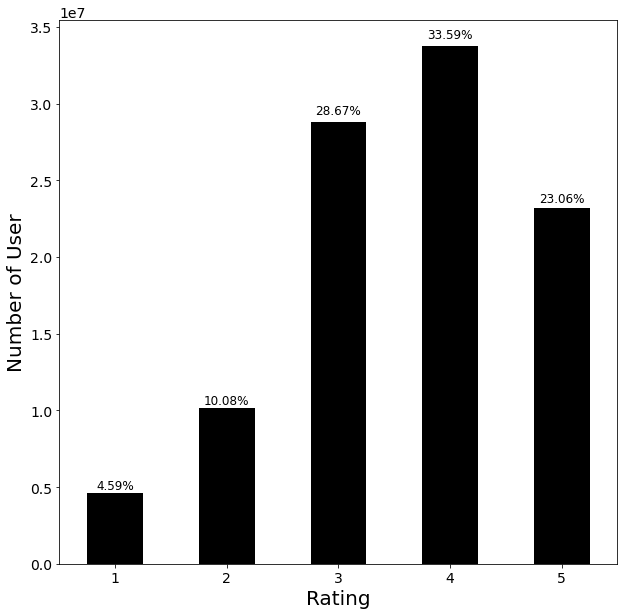

In [0]:
rating_dist = visualize_df['rating'].value_counts().sort_index(ascending=True)
labels = rating_dist / np.sum(rating_dist)
labels = labels.to_list()

fig, ax = plt.subplots(figsize = (10, 10))
ax = visualize_df['rating'].value_counts().sort_index(ascending=True).plot(kind = 'bar', color = 'black')
ax.set_xlabel('Rating')
ax.set_xticklabels([1,2,3,4,5], rotation = 'horizontal')
ax.set_ylabel('Number of User')

# Labeling purpose
bars = ax.patches
for bar, label in zip(bars, labels):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height*1.01, str('{:.2f}%'.format(label*100)) ,
            ha='center', va='bottom', fontsize = 'large')

fig.savefig('/content/drive/My Drive/Master Thesis - Clean/Figures/Global Rating Distribution.png', dpi = 500, bbox_inches = 'tight')

Furthermore, we also curious about the distribution of rating per day. Since the date information is present in the dataset, we group the rating per day and found out that **majority of ratings were given on Tuesday**. However, as shown in the second graph below, **the distribution of rating is reasonably similar each day**.

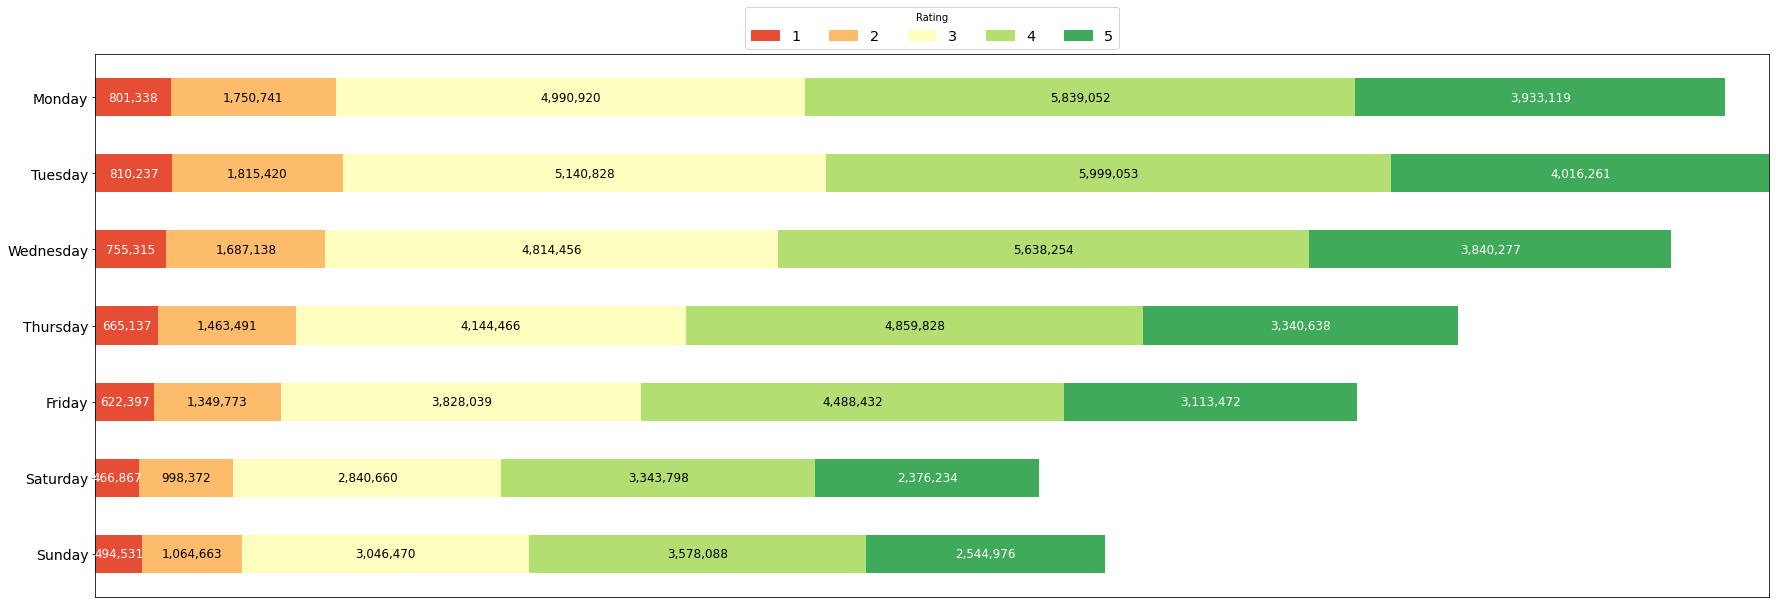

In [0]:
rating_per_day = visualize_df.groupby('day_name')['rating'].value_counts().sort_index(ascending = True)

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
rating = [1,2,3,4,5]
result = {}
for day in day_order:
  result[day] = list(rating_per_day.loc[day])

container = np.array(list(result.values()))
cumsum = container.cumsum(axis=1)
category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, container.shape[1]))

fig, ax = plt.subplots(figsize=(30, 10))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(container, axis=1).max())

for i, (colname, color) in enumerate(zip(rating, category_colors)):
  widths = container[:, i]
  starts = cumsum[:, i] - widths
  ax.barh(day_order, widths, left=starts, height=0.5,
          label=colname, color=color)
  xcenters = starts + widths / 2

  r, g, b, _ = color
  text_color = 'white' if r * g * b < 0.2 else 'black'
  for y, (x, c) in enumerate(zip(xcenters, widths)):
    ax.text(x, y, str('{:,}'.format(int(c))), ha='center', va='center',
            color=text_color, fontsize = 'large')
ax.legend(title ='Rating', ncol=len(rating), bbox_to_anchor=(0.5, 1.1), 
          loc='upper center', fontsize='x-large')

fig.savefig('/content/drive/My Drive/Master Thesis - Clean/Figures/Agg Rating per Day.png', dpi = 500, bbox_inches = 'tight')

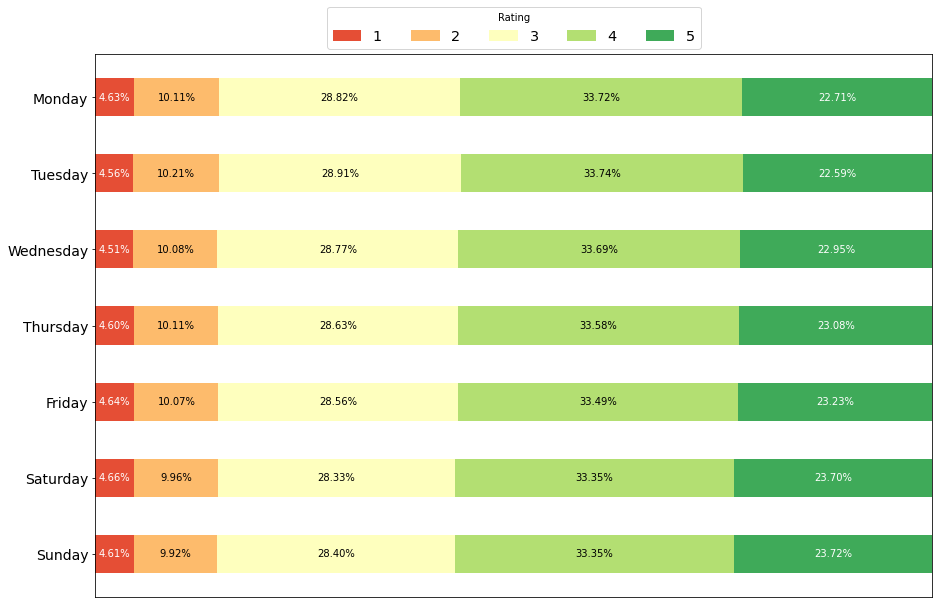

In [0]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
rating = [1,2,3,4,5]
result = {}
for day in day_order:
  result[day] = list(rating_per_day.loc[day])

container2 = np.zeros(shape=(container.shape))
container_sum = np.sum(container, axis=1)
for i in range(container.shape[0]):
  for j in range(container.shape[1]):
    container2[i,j] = float(container[i][j] / container_sum[i])

container2 = np.array(container2)
cumsum = container2.cumsum(axis=1)
category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, container2.shape[1]))

fig, ax = plt.subplots(figsize=(15, 10))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(container2, axis=1).max())

for i, (colname, color) in enumerate(zip(rating, category_colors)):
  widths = container2[:, i]
  starts = cumsum[:, i] - widths
  ax.barh(day_order, widths, left=starts, height=0.5,
          label=colname, color=color)
  xcenters = starts + widths / 2

  r, g, b, _ = color
  text_color = 'white' if r * g * b < 0.2 else 'black'
  for y, (x, c) in enumerate(zip(xcenters, widths)):
    ax.text(x, y, str('{:.2f}%'.format(float(c)*100)), ha='center', va='center',
            color=text_color)
ax.legend(title ='Rating', ncol=len(rating), bbox_to_anchor=(0.5, 1.1), 
          loc='upper center', fontsize='x-large')

fig.savefig('/content/drive/My Drive/Master Thesis - Clean/Figures/Rating Distribution per Day.png', dpi = 500, bbox_inches = 'tight')

We further investigate the dynamic of movies, users and ratings on a daily basis. For this purpose, we create a new dataframe that consists of:
1. Size and Average of daily rating
2. Accumulated Size and Average of daily rating
3. Standard deviation of daily rating.
4. Growth of user (per day and cumulative)
5. Growth of movie (per day and cumulative)
6. Proportion of user to total user (per day)
7. Proportion of movie to total movie (per day)
8. Daily rating size (real number and proportion to global rating)

In order to do that, we first determine helper functions as follows:

In [0]:
def get_cumulative_std(data, date_index):
  data = data['rating']
  container = pd.Series(data.loc[date_index[0]])
  value = [container.std()]
  for number in tqdm(range(1,len(date_index))):
    container = container.append(pd.Series(data.loc[date_index[number]]))
    value.append(container.std())
  return value

def get_new_unique(data, date_index, column):
  data = data[str(column)]
  container = pd.Series(data.loc[date_index[0]]).drop_duplicates()
  value = [container.count()]
  lag_user = 1
  for number in tqdm(range(1,len(date_index))):
    container = container.append(pd.Series(data.loc[date_index[number]].drop_duplicates()))
    container = container.drop_duplicates()
    new_container = container.count()
    new_member = new_container - lag_user
    lag_user = new_container
    value.append(int(new_member))
  return value

def daily_rating(data, rating):
  return pd.DataFrame(data[data['rating'] == rating].groupby('date').size().sort_index(ascending=True), columns=['rating_{}'.format(rating)]).reset_index()

We also moved "date" in visualize_df to index for query purpose. Thus, we proceed with the full code as follows:

In [0]:
### ------------------------------------------------------------------------ ###
### -------------------   !!! HEAVY PROCESS AHEAD !!!   -------------------- ###
### ----------------------   Proceed with cautions   ----------------------- ###
### ------------------------------------------------------------------------ ###

### --------------   Make "date" as index for query purpose   -------------- ###
visualize_df.sort_values(by=['date'], inplace=True)
visualize_df.set_index(['date'], inplace=True)

### ------   New Dataframe consist of User, Movie and Rating growth   ------ ###
### Daily mean of rating --------------------------------------------------- ###
avg_daily_rating = df.groupby('date')['rating'].mean().sort_index(ascending=True)
### Number of Rating per Day ----------------------------------------------- ###
num_rating_daily = df.groupby('date').size()
### Number of Rating per Day (cumulative) ---------------------------------- ###
cum_num_rating_daily = df.groupby('date').size().cumsum()
### Sum of Rating per day (cumulative) ------------------------------------- ###
sum_rating_daily = df.groupby('date')['rating'].sum().cumsum()

cumulative_rating = pd.DataFrame({'date': num_rating_daily.index, 
                                  'average_rating': avg_daily_rating.values,
                                  'daily_rating': num_rating_daily.values,
                                  'cum_num_rating': cum_num_rating_daily.values, 
                                  'cum_rating': sum_rating_daily.values})

### Average of cumulative rating per Day ----------------------------------- ###
cumulative_rating['avg_cum_rating'] = cumulative_rating['cum_rating'].divide(cumulative_rating['cum_num_rating'])
### Standard Deviation of rating per Day (cumulative) ---------------------- ###
cumulative_rating['cum_std'] = get_cumulative_std(visualize_df, num_rating_daily.index.tolist())
### Number of New User per day --------------------------------------------- ###
cumulative_rating['new_user_daily'] = get_new_unique(visualize_df, num_rating_daily.index.tolist(), 'user_id')
### Number of New Movie per day -------------------------------------------- ###
cumulative_rating['new_movie_daily'] = get_new_unique(visualize_df, num_rating_daily.index.tolist(), 'movie_id')
### Number of New User per day (cumulative) -------------------------------- ###
cumulative_rating['cum_new_user'] = cumulative_rating['new_user_daily'].cumsum()
### Proportion of New User per Day to Total User --------------------------- ###
cumulative_rating['pct_new_user'] = cumulative_rating['cum_new_user'].divide(len(df['user_id'].unique()))
### Number of New Movie per day (cumulative) ------------------------------- ###
cumulative_rating['cum_new_movie'] = cumulative_rating['new_movie_daily'].cumsum()
### Proportion of New Movie per Day to Total Movie ------------------------- ###
cumulative_rating['pct_new_movie'] = cumulative_rating['cum_new_movie'].divide(len(df['movie_id'].unique()))

### Get the details for every rating per day ------------------------------- ###
for i in tqdm(range(5)):
  cumulative_rating = pd.merge(cumulative_rating, daily_rating(df, i+1), how = 'left', on = 'date')
  cumulative_rating['rating_{}'.format(i+1)] = cumulative_rating['rating_{}'.format(i+1)].fillna(0)
  cumulative_rating['cum_rating_{}'.format(i+1)] = cumulative_rating['rating_{}'.format(i+1)].cumsum()
  cumulative_rating['pct_rating_{}'.format(i+1)] = cumulative_rating['rating_{}'.format(i+1)].divide(cumulative_rating['daily_rating'])
  cumulative_rating['pct_cum_rating_{}'.format(i+1)] = cumulative_rating['cum_rating_{}'.format(i+1)].divide(cumulative_rating['cum_num_rating'])

display(cumulative_rating)

100%|██████████| 5/5 [00:12<00:00,  2.58s/it]


,date,average_rating,daily_rating,cum_num_rating,cum_rating,avg_cum_rating,cum_std,new_user_daily,new_movie_daily,cum_new_user,pct_new_user,cum_new_movie,pct_new_movie,rating_1,cum_rating_1,pct_rating_1,pct_cum_rating_1,rating_2,cum_rating_2,pct_rating_2,pct_cum_rating_2,rating_3,cum_rating_3,pct_rating_3,pct_cum_rating_3,rating_4,cum_rating_4,pct_rating_4,pct_cum_rating_4,rating_5,cum_rating_5,pct_rating_5,pct_cum_rating_5
0,1999-11-11,3.428571,28,28,96.0,3.428571,1.168366,1,28,1,0.000002,28,0.001576,0.0,0.0,0.000000,0.000000,8.0,8.0,0.285714,0.285714,7,7,0.250000,0.250000,6.0,6.0,0.214286,0.214286,7.0,7.0,0.250000,0.250000
1,1999-12-06,3.333333,12,40,136.0,3.400000,1.081310,0,39,1,0.000002,67,0.003770,0.0,0.0,0.000000,0.000000,1.0,9.0,0.083333,0.225000,8,15,0.666667,0.375000,1.0,7.0,0.083333,0.175000,2.0,9.0,0.166667,0.225000
2,1999-12-08,3.655172,29,69,242.0,3.507246,1.051934,1,27,2,0.000004,94,0.005290,0.0,0.0,0.000000,0.000000,4.0,13.0,0.137931,0.188406,9,24,0.310345,0.347826,9.0,16.0,0.310345,0.231884,7.0,16.0,0.241379,0.231884
3,1999-12-09,3.487500,80,149,521.0,3.496644,1.148584,2,57,4,0.000008,151,0.008497,8.0,8.0,0.100000,0.053691,8.0,21.0,0.100000,0.140940,19,43,0.237500,0.288591,27.0,43.0,0.337500,0.288591,18.0,34.0,0.225000,0.228188
4,1999-12-10,3.666667,21,170,598.0,3.517647,1.126462,0,17,4,0.000008,168,0.009454,1.0,9.0,0.047619,0.052941,0.0,21.0,0.000000,0.123529,8,51,0.380952,0.300000,8.0,51.0,0.380952,0.300000,4.0,38.0,0.190476,0.223529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,2005-12-27,3.636882,87517,100144406,360932809.0,3.604124,1.085247,93,0,479827,0.999248,17797,1.001519,3983.0,4603615.0,0.045511,0.045970,8034.0,10102177.0,0.091799,0.100876,25202,28714478,0.287967,0.286731,28858.0,33639274.0,0.329742,0.335908,21440.0,23084862.0,0.244981,0.230516
2178,2005-12-28,3.657669,98469,100242875,361292976.0,3.604176,1.085212,111,0,479938,0.999479,17797,1.001519,3413.0,4607028.0,0.034661,0.045959,8896.0,10111073.0,0.090343,0.100866,29509,28743987,0.299678,0.286743,32820.0,33672094.0,0.333303,0.335905,23831.0,23108693.0,0.242015,0.230527
2179,2005-12-29,3.686350,97086,100339961,361650869.0,3.604256,1.085188,112,0,480050,0.999713,17797,1.001519,3676.0,4610704.0,0.037863,0.045951,8211.0,10119284.0,0.084575,0.100850,27574,28771561,0.284016,0.286741,33052.0,33705146.0,0.340440,0.335909,24573.0,23133266.0,0.253105,0.230549
2180,2005-12-30,3.675675,77339,100417300,361935142.0,3.604311,1.085182,86,0,480136,0.999892,17797,1.001519,3219.0,4613923.0,0.041622,0.045947,6735.0,10126019.0,0.087084,0.100839,21772,28793333,0.281514,0.286737,25797.0,33730943.0,0.333557,0.335908,19816.0,23153082.0,0.256223,0.230569


Creating this dataframe is essential for visualization. We then investigate the real number of rating per day. From the graph below, we could observe that number of rating in the dataset per day is highly fluctuated. This dynamic could also indicate on how our experiment would be. Since the number of daily rating is continuosly increased until day 2000, then we suspect that our test set would also grow as the update proceed.

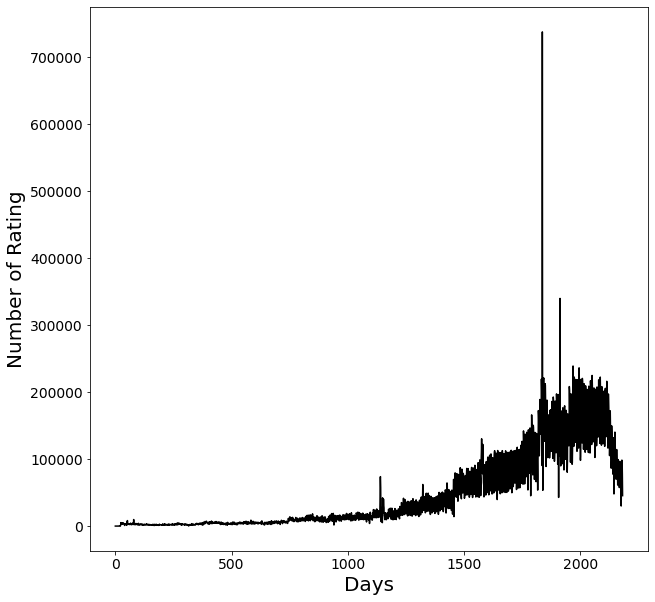

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(cumulative_rating['daily_rating'], color = 'black')
ax.set_xlabel('Days')
ax.set_ylabel('Number of Rating')

fig.savefig('/content/drive/My Drive/Master Thesis - Clean/Figures/New Rating per Day.png', dpi = 500, bbox_inches = 'tight')

Furthermore, we also investigate the mean of daily rating. From the graph below, we could observe that the mean of daily rating increase after day 1500. To understand what happend, we further visualize the movement of individual rating over time

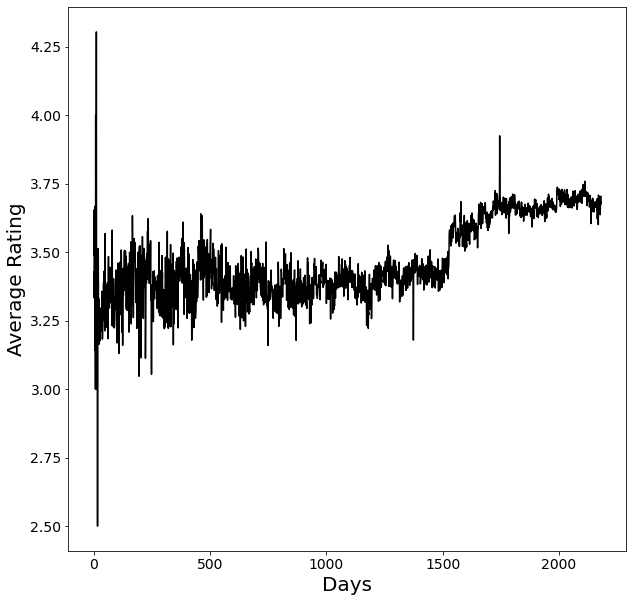

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(cumulative_rating['average_rating'], color = 'black')
ax.set_xlabel('Days')
ax.set_ylabel('Average Rating')

fig.savefig('/content/drive/My Drive/Master Thesis - Clean/Figures/Daily mean rating.png', dpi = 500, bbox_inches = 'tight')

From the graph below, we could observe the tendency of user to give rating 4 for a movie since day 1000, overtook the rating 3 as the majority rating. Moreover, rating 5 is also increase sharply after day 1500. This explains higher average daily rating after day 1500 as shown previously.

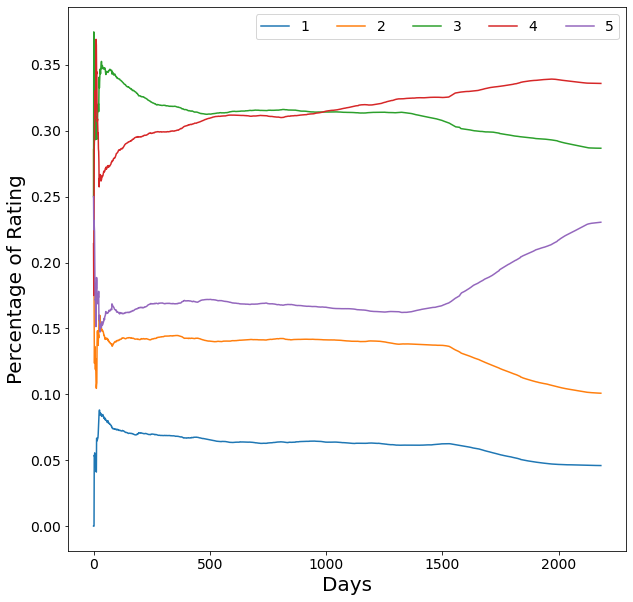

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
for i in range(5):
  cumulative_rating['pct_cum_rating_{}'.format(i+1)].plot(kind='line', ax = ax, label='{}'.format(i+1))
ax.set_xlabel('Days')
ax.set_xticks([0,500,1000,1500,2000])
ax.set_ylabel('Percentage of Rating')
ax.legend(fontsize=14, ncol = 5)

fig.savefig('/content/drive/My Drive/Master Thesis - Clean/Figures/Percentage Rating over time.png', dpi = 500, bbox_inches = 'tight')

We further investigate the continuous mean of rating. Continuous mean of rating at time $n$ defined as mean of rating from time $t = 0$ until time $t = n$. From the graph below, we found that the continuous mean of rating relatively stable after day 500 before increase from day 1500 onwards, due to increase in rating 5 as previously discussed.

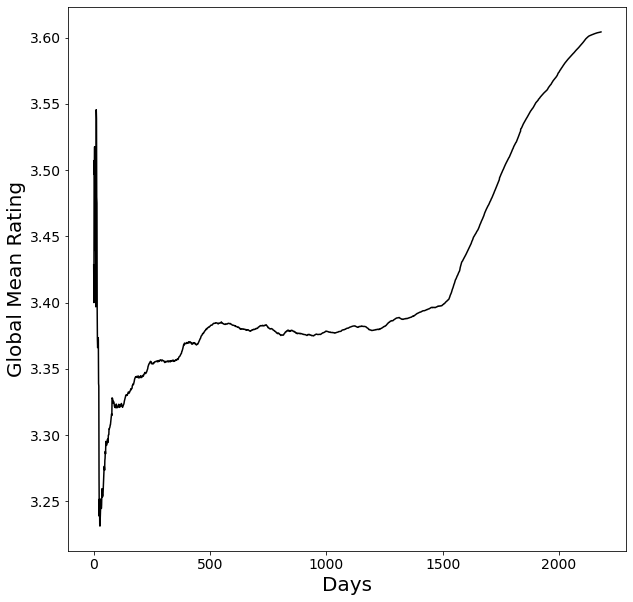

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(cumulative_rating['avg_cum_rating'], color = 'black')
ax.set_xlabel('Days')
ax.set_ylabel('Global Mean Rating')

fig.savefig('/content/drive/My Drive/Master Thesis - Clean/Figures/Mean Cumulative Rating.png', dpi = 500, bbox_inches = 'tight')

Similar to continuous mean of rating, its standard deviation also suffers from high fluctuation in early 500 days and continuously to decrease from 1.2 in day 500 to 1.08 in day 1982. It also highlights the tendency of a user to give higher rating overall, due to decrease in its standard deviation.

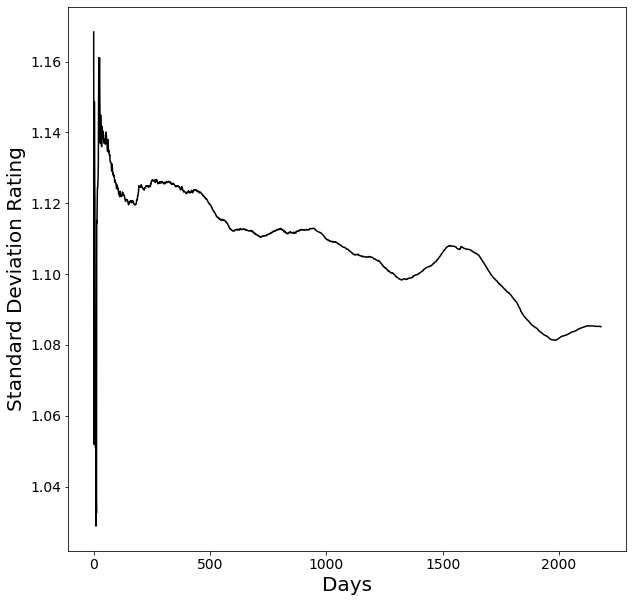

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(cumulative_rating['cum_std'], color = 'black')
ax.set_xlabel('Days')
ax.set_ylabel('Standard Deviation Rating')

fig.savefig('/content/drive/My Drive/Master Thesis - Clean/Figures/Mean Cumulative Standard Deviation.png', dpi = 500, bbox_inches = 'tight')

Moreover, to understand the dynamic of user in the dataset, we also investigate daily new user addition to dataset. From graph below, we could observe increase in new user addition after day 1000. This might cause a problem when the algorithms try to make prediction for a user without previous rating history. We will solve this problem by pruning the test set to include user that has minimum 1 rating history in the training set.

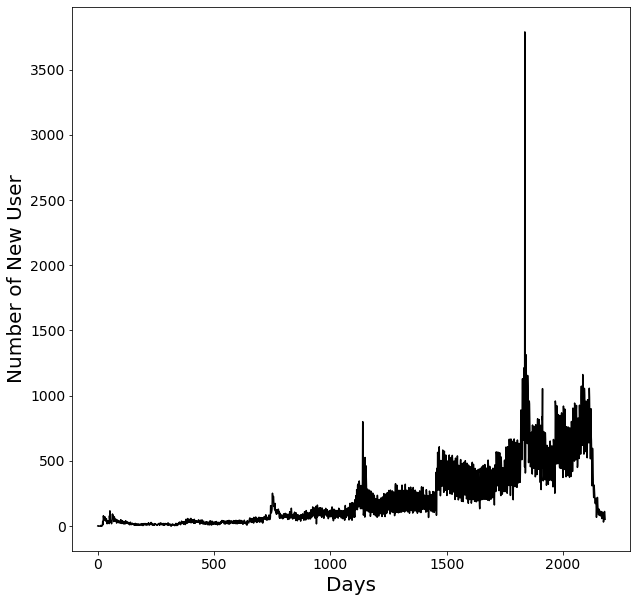

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(cumulative_rating['new_user_daily'], color = 'black')
ax.set_xlabel('Days')
ax.set_ylabel('Number of New User')

fig.savefig('/content/drive/My Drive/Master Thesis - Clean/Figures/New User per Day.png', dpi = 500, bbox_inches = 'tight')

To better understand the growth of new user, we plot accumulated new user per day as real number and as proportion to total user. As we could observe in the graphs below, the growth of new user shows exponential growth over the course of observation period.

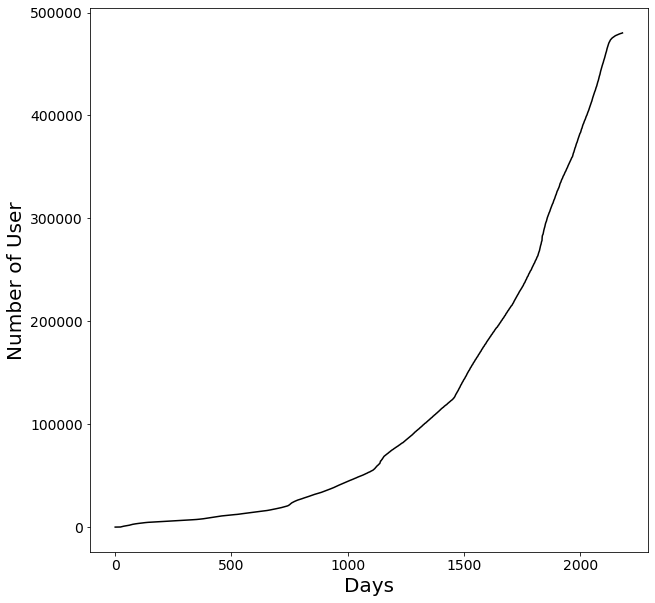

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(cumulative_rating['cum_new_user'], color = 'black')
ax.set_xlabel('Days')
ax.set_ylabel('Number of User')

fig.savefig('/content/drive/My Drive/Master Thesis - Clean/Figures/Cumulative New User.png', dpi = 500, bbox_inches = 'tight')

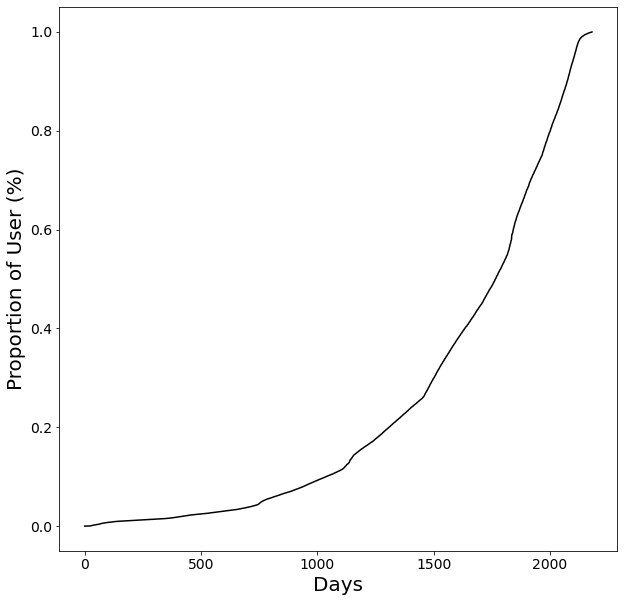

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(cumulative_rating['pct_new_user'], color = 'black')
ax.set_xlabel('Days')
ax.set_ylabel('Proportion of User (%)')

fig.savefig('/content/drive/My Drive/Master Thesis - Clean/Figures/Cumulative User Growth.png', dpi = 500, bbox_inches = 'tight')

We also investigate the dynamic of movie in the dataset. Unlike growth of new user, as shown in the graph below, the growth of new movie per day shows relatively stable trends with a few days with daily growth of new movie more than 50 movies. We will also prun our test set in this experiment to include only movie that has minimum 1 rating history in the dataset to prevent the algorithms to make prediction for movie without any historical rating.

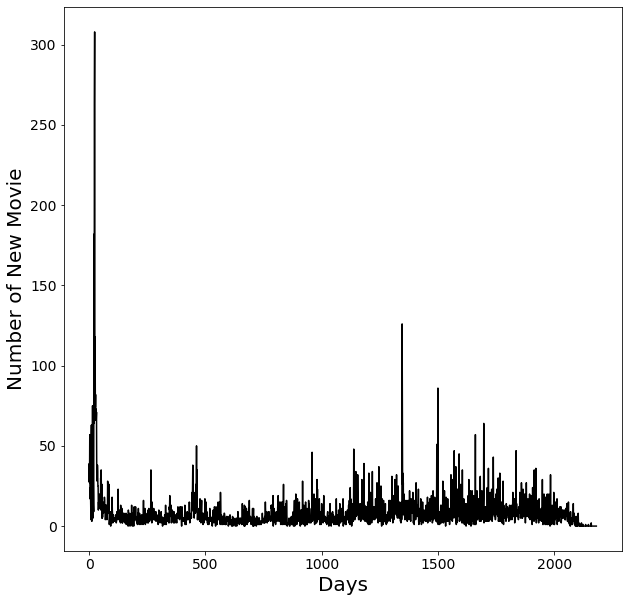

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(cumulative_rating['new_movie_daily'], color = 'black')
ax.set_xlabel('Days')
ax.set_ylabel('Number of New Movie')

fig.savefig('/content/drive/My Drive/Master Thesis - Clean/Figures/New Movie per Day.png', dpi = 500, bbox_inches = 'tight')

Furthermore, we also plot accumulated new movie per day as real number and as proportion to total movie. The graphs below show linear growth in new movie over the course of observation period.

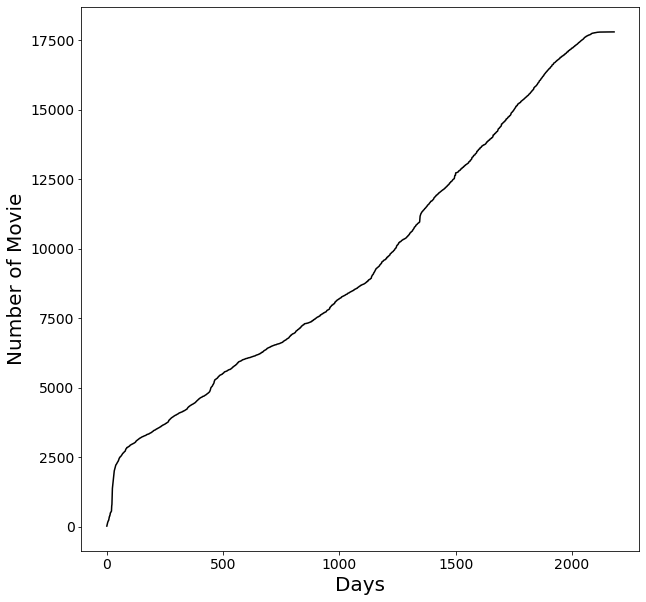

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(cumulative_rating['cum_new_movie'], color = 'black')
ax.set_xlabel('Days')
ax.set_ylabel('Number of Movie')

fig.savefig('/content/drive/My Drive/Master Thesis - Clean/Figures/Cumulative New Movie.png', dpi = 500, bbox_inches = 'tight')

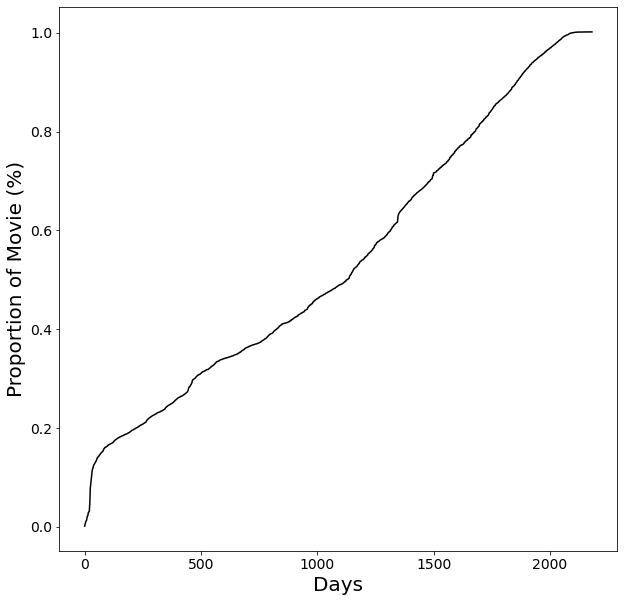

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(cumulative_rating['pct_new_movie'], color = 'black')
ax.set_xlabel('Days')
ax.set_ylabel('Proportion of Movie (%)')

fig.savefig('/content/drive/My Drive/Master Thesis - Clean/Figures/Cumulative Movie Growth.png', dpi = 500, bbox_inches = 'tight')

#3. Experiment Design

In this research, we would evaluate the temporal performance of 4 algorithms, namely (1) User-based k-NN Algorithm, (2) Item-based k-NN algorithm, (3) **S**ingular **V**alue **D**ecomposition (SVD) algorithm, and (4) SVD with implicit feedback (SVD++) algorithm. Due to computing power constraint, we would sample the dataset using stratified sampling technique based on the profile size of a user (the number of rating a user had given in the datset). We use this sampling technique to retain the distribution of sampled dataset similar to the full dataset.

We deploy temporal evaluation techniques proposed by Lathia (2010). Firstly, we determine the edge time $\epsilon$: the cutoff time in the dataset for which the system will be trained upon for the first time. Deciding $\epsilon$ is crucial to alleviate system-wide cold-start problem, in which the system has to predict the rating for a user without any historical rating. We also decide our system update interval $\upsilon$ to monthly update $\upsilon = 30$-days. **Performance evaluation is conducted by following the rule that at time $\tau_t$, prediction error would be evaluated on data at $\tau_t + \upsilon$. The data in $\tau_t + \upsilon$ then incrementally added to the training data $\tau_{t+1} = \tau_t + \upsilon$ and evaluated on $\tau_{t+1} + \upsilon$, repeatedly until the last time point in the dataset.** The graphical ilustration of this rule is as follows:

![Update Design]( https://docs.google.com/uc?export=download&id=1FGK1diAIOzuN0KMbBEQrtAFNvs_8p4zF)

As previously discussed, we would also prun the test set for every update to include user-movie interaction that has minimum 1 historical rating in the training set each update. It is important to note that, we will only perform prediction once every system update. This prediction is then evaluated using RMSE and time-averaged RMSE. Time-averaged RMSE defined as follows: 
<br>
<br>$$\begin{equation} RMSE_\tau = \sqrt{\frac{\sum_{\hat{r}_{u,i} \in R_\tau}^N (\hat{r}_{u,i} - r_{u,i})^2}{|R_\tau|}}
\end{equation}$$

<br>In above equation, $R_\tau$ denotes all the prediction made by the algorithms from the first evaluation until most recent update. Incorporating both method will give us insight on the performance at one given time point as well as cumulative performance. 

In [0]:
### ---------------------   Load the Library back in   --------------------- ###
### -----------   Just in case your kernel died in the middle   ------------ ###
### -------------   Else, just skip this and the code below   -------------- ###
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

%matplotlib inline
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

In [0]:
wd = '/content/drive/My Drive/Master Thesis - Clean/Dataset/' # dataset Directory
df = pd.read_feather(wd+'df_concat.feather')
df.sort_values(by=['date'], inplace=True)
df.set_index(['date'], inplace=True)
display(df)

,user_id,rating,movie_id
date,,,
1999-11-11,510180,5.0,11234
1999-11-11,510180,4.0,8357
1999-11-11,510180,5.0,6615
1999-11-11,510180,5.0,1367
1999-11-11,510180,3.0,9392
...,...,...,...
2005-12-31,1271554,5.0,10451
2005-12-31,2036838,4.0,2561
2005-12-31,76465,5.0,9592


In this research, we sample the dataset using stratified sampling technique based on profile size of each user (the number of rating a user had given in the dataset). We devide into 50 categories of profile. From each category, we randomly sample 2.5% user to be included in the experiment.

In [0]:
### -----------------------   Sampling the dataset   ----------------------- ###
# Get the profile size
profile = df.groupby('user_id')['rating'].size()
profile = pd.DataFrame(profile.values, columns = ['size'], index=profile.index)
profile.reset_index(inplace=True)

# Grouping each user using quantile cut.
profile['groups'] = pd.qcut(profile['size'], np.linspace(0, 1, num = 51))

# We perform stratified random sampling from each profile size
sample_data = profile.groupby('groups').apply(lambda s: s.sample(frac = 0.025, random_state = 24))
sample_data = sample_data.reset_index(drop=True)
sample_user = sample_data.user_id.tolist()
sample_df = df[df['user_id'].isin(sample_user)]

### ---------------------------   Sanity Check   --------------------------- ###
n_user = len(sample_df['user_id'].unique())
n_movie = len(sample_df['movie_id'].unique())
mean_rating = sample_df['rating'].mean()
std_rating = sample_df['rating'].std()
min_rating = sample_df['rating'].min()
max_rating = sample_df['rating'].max()
start = sample_df.index.min()
end = sample_df.index.max()
df_len = sample_df.shape[0]

# Print Output
print('='*80)
print('SUMMARY STATISTICS AFTER SAMPLING')
print('='*80)
print('Number of user = {:,}'.format(n_user))
print('Number of movie = {:,}'.format(n_movie))
print('The dataset span from {} until {}, which is {:,} days'.format(start.strftime("%d/%m/%Y"), end.strftime("%d/%m/%Y"), (end-start).days))
print('Total rating available after stratified sampling is {:,} ranging from {:.0f} to {:.0f} with average of {:.2f} and standard deviation of {:.2f}'.format(
    df_len, min_rating, max_rating, mean_rating, std_rating))

SUMMARY STATISTICS AFTER SAMPLING
Number of user = 12,006
Number of movie = 17,509
The dataset span from 27/12/1999 until 31/12/2005, which is 2,196 days
Total rating available after stratified sampling is 2,519,931 ranging from 1 to 5 with average of 3.60 and standard deviation of 1.08


From sampling technique that we deploy, we retain the average and standard deviation of rating in the dataset relatively similar to the full dataset. We further investigate the proportion of rating in this sampled data

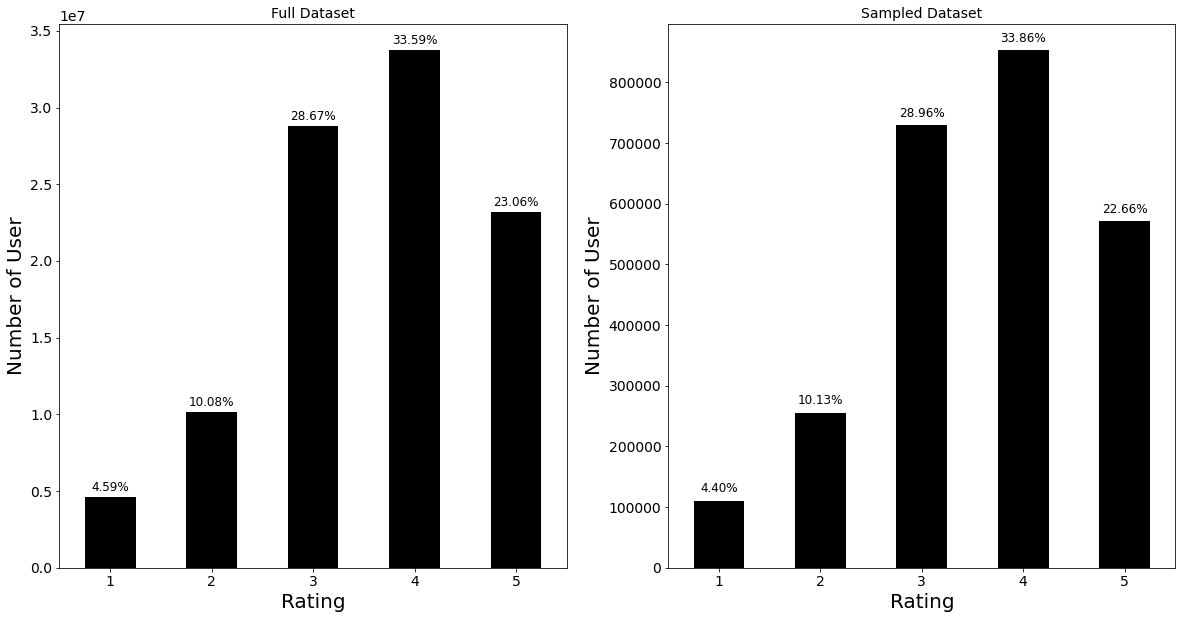

In [0]:
### ---------------------------   Full Dataset   --------------------------- ###
rating_full = df['rating'].value_counts().sort_index(ascending=True)
labels_full = rating_full / np.sum(rating_full)
labels_full = labels_full.to_list()

### -------------------------   Sampled Dataset   -------------------------- ###
rating_sample = sample_df['rating'].value_counts().sort_index(ascending=True)
labels_sample = rating_sample / np.sum(rating_sample)
labels_sample = labels_sample.to_list()

### -----------------------------   Plotting   ----------------------------- ###
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

# AX[0]
rating_full.plot(kind = 'bar', ax = ax[0], color = 'black')
ax[0].set_xlabel('Rating')
ax[0].set_xticklabels([1,2,3,4,5], rotation = 'horizontal')
ax[0].set_ylabel('Number of User')
ax[0].set_title('Full Dataset')
# Labeling Purpose
bars1 = ax[0].patches
for bar, label in zip(bars1, labels_full):
    height = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width() / 2, height+2e5, str('{:.2f}%'.format(label*100)) ,
            ha='center', va='bottom', fontsize = 'large')
    
# AX[1]
rating_sample.plot(kind = 'bar', ax = ax[1], color = 'black')
ax[1].set_xlabel('Rating')
ax[1].set_xticklabels([1,2,3,4,5], rotation = 'horizontal')
ax[1].set_ylabel('Number of User')
ax[1].set_title('Sampled Dataset')
# Labeling Purpose
bars2 = ax[1].patches
for bar, label in zip(bars2, labels_sample):
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width() / 2, height+9e3, str('{:.2f}%'.format(label*100)) ,
            ha='center', va='bottom', fontsize = 'large')

We could observe in the graphs above that rating distribution for sampled data is also relatively similar to the distribution in the full dataset. From this result, we proceed to make the split based on rules we mentioned earlier. For this task, we first create a list that consist the date in the dataset.

In [0]:
date_list = sample_df.index.unique().tolist()
date_list = sorted(date_list)

### ---------------------------   Sanity Check   --------------------------- ###
display(date_list[:10])

[Timestamp('1999-12-27 00:00:00'),
 Timestamp('1999-12-31 00:00:00'),
 Timestamp('2000-01-06 00:00:00'),
 Timestamp('2000-01-07 00:00:00'),
 Timestamp('2000-01-08 00:00:00'),
 Timestamp('2000-01-09 00:00:00'),
 Timestamp('2000-01-10 00:00:00'),
 Timestamp('2000-01-11 00:00:00'),
 Timestamp('2000-01-12 00:00:00'),
 Timestamp('2000-01-13 00:00:00')]

We also mentioned earlier that we prun the dataset in each system update to include minimum user-movie interaction that has 1 historical rating in the training set. To perform this task, we first investigate the date of first rating for each user and movie.

In [0]:
# Get the first rating date for each user
user_list = sample_df[sample_df.index == date_list[0]].user_id.unique().tolist()
user_date = [date_list[0]] * len(user_list)
for date in tqdm(date_list[1:]):
  tmp = sample_df[sample_df.index == date].user_id.unique().tolist()
  tmp_2 = list(set(tmp) - set(user_list))
  if len(tmp_2) > 0:
    len_date = [date]*len(tmp_2)
    user_list.extend(tmp_2)
    user_date.extend(len_date)
  else: pass

# Get the first rating date for each movie
movie_list = sample_df[sample_df.index == date_list[0]].movie_id.unique().tolist()
movie_date = [date_list[0]] * len(movie_list)
for date in tqdm(date_list[1:]):
  tmp = sample_df[sample_df.index == date].movie_id.unique().tolist()
  tmp_2 = list(set(tmp) - set(movie_list))
  if len(tmp_2) > 0:
    len_date = [date]*len(tmp_2)
    movie_list.extend(tmp_2)
    movie_date.extend(len_date)
  else: pass

# Store the result to Series
user_first_rating_date = pd.Series(user_list, index=[user_date])
movie_first_rating_date = pd.Series(movie_list, index=[movie_date])

100%|██████████| 2154/2154 [00:12<00:00, 171.18it/s]


Furthermore, for each update, we create training and test set and save it to csv. In this sense, we use the list we created earlier that consist of all date in the dataset. We then use timedelta to calculate the edge time $\epsilon = 500$ days and every other checkpoints for each system update. For this research, we perform 57 system updates.

In [0]:
### --------   Investigate how many update we will be performing   --------- ###
tmp = date_list[-1] - date_list[0]
remaining_days = tmp.days - 500

# If the remaining days is not devisible by 30, then we add one more update that
# consist of the remaining days. Otherwise, keep as is.
if remaining_days % 30 > 0:
  split = (remaining_days // 30) + 1
else: split = remaining_days / 30


### --   Create separated training and test data for each system update   -- ###
training_path = '/content/drive/My Drive/Master Thesis - Clean/Dataset/training/'
test_path = '/content/drive/My Drive/Master Thesis - Clean/Dataset/test/'
checkpoint = date_list[0]

for i in tqdm(range(split)):
  if i == 0:
    checkpoint += dt.timedelta(days = 500)
    training = sample_df[:checkpoint]
    training.to_csv(training_path+'train {}.csv'.format(i), index = False)
    
    # Get test candidate
    test = sample_df[checkpoint + dt.timedelta(days = 1) : checkpoint + dt.timedelta(days = 30)]
    
    # Pruning the test set, to contain minimum 1 interaction in training data
    test = test[test['user_id'].isin(user_first_rating_date[:checkpoint].values)]
    test = test[test['movie_id'].isin(movie_first_rating_date[:checkpoint].values)]
    test.to_csv(test_path+'test {}.csv'.format(i), index = False)

    checkpoint += dt.timedelta(days = 30)
  
  # For the last update, the test set would consist of 30 days if the remaining
  # days is divisible by 30. Otherwise, it would consist only from the last check
  # point until the last date in the dataset. In this research, the last update 
  # would worth 2 days of test set.
  elif i == (split-1):
    training = sample_df[:checkpoint]
    training.to_csv(training_path+'train {}.csv'.format(i), index = False)
    
    # Get test candidate
    test = sample_df[checkpoint + dt.timedelta(days = 1) : ]
    
    # Pruning the test set, to contain minimum 1 interaction in training data
    test = test[test['user_id'].isin(user_first_rating_date[:checkpoint].values)]
    test = test[test['movie_id'].isin(movie_first_rating_date[:checkpoint].values)]
    test.to_csv(test_path+'test {}.csv'.format(i), index = False)
  
  else:
    training = sample_df[:checkpoint]
    training.to_csv(training_path+'train {}.csv'.format(i), index = False)

    # Get test candidate
    test = sample_df[checkpoint + dt.timedelta(days = 1) : checkpoint + dt.timedelta(days = 30)]
    
    # Pruning the test set, to contain minimum 1 interaction in training data
    test = test[test['user_id'].isin(user_first_rating_date[:checkpoint].values)]
    test = test[test['movie_id'].isin(movie_first_rating_date[:checkpoint].values)]
    test.to_csv(test_path+'test {}.csv'.format(i), index = False)

    checkpoint += dt.timedelta(days = 30)

100%|██████████| 57/57 [03:49<00:00,  4.02s/it]


It is also worth noting that, whilst the size of training set grows as the system update increase, the size of the test set also grows as shown in the graph below.  

100%|██████████| 57/57 [00:38<00:00,  1.49it/s]


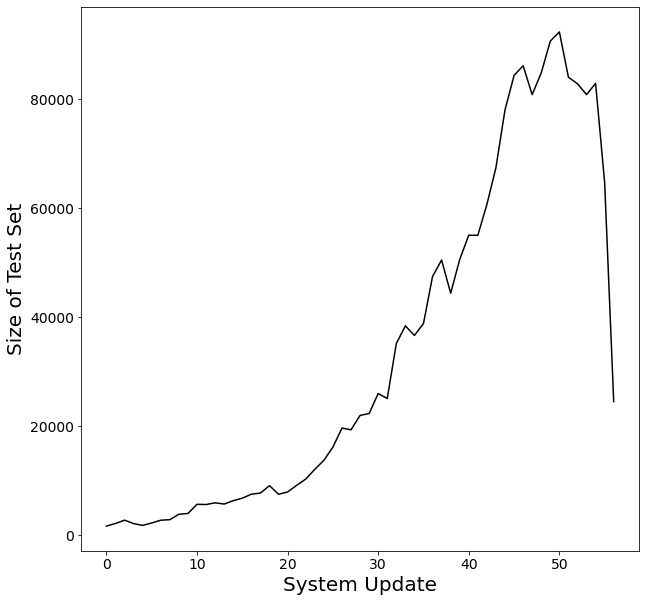

In [0]:
### -----------   Check the number of file in test set folder   ------------ ###
_, _, files = next(os.walk(test_path))
updates = len(files)

### ---------   Inspect the size of test set every system update   --------- ###
test_size = list()
for i in tqdm(range(updates)):
  test = pd.read_csv(test_path+'test {}.csv'.format(i))
  test_size.append(len(test))

### -----------------------------   Plotting   ----------------------------- ###
test_size = pd.Series(test_size)
fig, ax = plt.subplots(figsize = (10, 10))
test_size.plot(kind = 'line', ax = ax, color = 'black')
ax.set_xlabel('System Update')
ax.set_ylabel('Size of Test Set')

fig.savefig('/content/drive/My Drive/Master Thesis - Clean/Figures/Test Set Size over system updates.png', dpi = 500, bbox_inches = 'tight')

At this point, we have the data splited based on the system updates and ready to evaluate our algorithms. As previously mentioned, we will evaluate 4 algorithms in this research, namely (1) User-based k-NN Algorithm, (2) Item-based k-NN algorithm, (3) **S**ingular **V**alue **D**ecomposition (SVD) algorithm, and (4) SVD with implicit feedback (SVD++) algorithm.
<br>
<br>
Lathia (2010) suggests that the performance of k-NN based algorithms depend on the value of $k$ the algorithms are evaluated on. In this research, we will be using 5 different $k$ values, which are 10, 20, 30, 40 and 50. The similarities measure we will be using is Pearson Correlation.
<br>
<br>
Moreover, we also use the same 5 different values as $k$ for number of factors in SVD and SVD++ algorithms. For every factor, SVD and SVD++ will be trained using 30 epochs. We follow Koren and Bell (2015) to set the learning rate and regularization for SVD algorithm to $[lr = 0.005, reg = 0.02]$ and for SVD++ algorithm to $[lr = 0.007, reg = 0.02]$.
<br>
<br>
Whilst User-based k-NN algorithm, Item-based k-NN algorithm and SVD algorithm will be executed on Google Colab environment, SVD++ algorithm will partly executed using Macbook Pro with 2.3 GHz 8-Core Intel Core i9 and 16GB of RAM. This is due to the fact that running SVD++ algorithm is resource and time-consuming and Google Colab does not support parallel processing for free user.
<br>
<br>
We generate prediction and manually compute the RMSE and Time-average RMSE for each system update. This process means that each system update would only be evaluated once.

In [0]:
### -------------------   Installing Surprise Library   -------------------- ###
# It appears that surprise is not readily installed in Google Colab
!pip install scikit-surprise

     |████████████████████████████████| 6.5MB 5.7MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1673638 sha256=6b6945177aaca552d96c168b745001783551f3460f09c9489958b5c5a0a6a33d
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
### -------------------   Importing Necessary Library   -------------------- ###
from datetime import datetime
from surprise import Dataset
from surprise import Reader
from surprise import KNNBasic
from surprise import SVD
from surprise import SVDpp

training_path = '/content/drive/My Drive/Master Thesis - Clean/Dataset/training/'
test_path = '/content/drive/My Drive/Master Thesis - Clean/Dataset/test/'
result_path = '/content/drive/My Drive/Master Thesis - Clean/Dataset/result/'
dump_path = '/content/drive/My Drive/Master Thesis - Clean/Dataset/dump/'

## 3.1 User-based k-NN

In [0]:
tag = 'User-based k-NN Algorithm'

# Inspect the number of system update
_, _, files = next(os.walk(training_path))
updates = len(files)

# Time logging
start = datetime.now()

# Specify number of k
kNN = [10, 20, 30, 40, 50]

# Storing result
dump = dict()
RMSE = dict()
time_RMSE = dict()

for i in range(updates):
  training = pd.read_csv(training_path+'train {}.csv'.format(i))
  test = pd.read_csv(test_path+'test {}.csv'.format(i))
  print('Processing system update {}'.format(i))
  print("="*80)
  start_update = datetime.now()

  # Load the dataset to Surprise environment
  reader = Reader(rating_scale=(1, 5))
  train_set = Dataset.load_from_df(training[['user_id', 'movie_id', 'rating']], reader).build_full_trainset()
  test_set = Dataset.load_from_df(test[['user_id', 'movie_id', 'rating']], reader).build_full_trainset().build_testset()

  # Training Phase
  ub_option = {'name': 'pearson', 'user_based': True}
  for k in kNN:
    print('Running kNN for k = {}'.format(k))
    start_training = datetime.now()
    ub = KNNBasic(k = k, sim_options = ub_option, verbose = False)
    ub.fit(train_set)
    cp1 = datetime.now()
    print("Training done in {}".format(cp1-start_training))

    # Prediction Phase
    ub_pred = ub.test(test_set)
    cp2 = datetime.now()
    print("Testing done in {}".format(cp2-cp1))

    result = pd.DataFrame(ub_pred, columns=['user_id', 'item_id', 'rating', 'pred', 'details'])
    if i == 0:
      dump[k] = result
    else: dump[k] = dump[k].append(result, ignore_index = True)
    dump_df = pd.DataFrame.from_dict(dump[k])
    dump_df.to_csv(dump_path+tag+' dump k {}.csv'.format(k))

    # Computing RMSE
    MAE_result = np.mean((result.pred - result.rating)**2)
    if i == 0:
      RMSE[k] = [np.sqrt(MAE_result)]
    else: RMSE[k].append(np.sqrt(MAE_result))
    print("RMSE = {:.2f}".format(RMSE[k][i]))

    # Computing time-averaged RMSE
    MAE_dump = np.mean((dump[k].pred - dump[k].rating)**2)
    if i == 0:
      time_RMSE[k] = [np.sqrt(MAE_result)]
    else: time_RMSE[k].append(np.sqrt(MAE_dump))
    print("Time-averaged RMSE = {:.2f}".format(time_RMSE[k][i]))
    print("k = {} done in {}".format(k, (cp2-start_training)))
    print('*'*80)

  end_update = datetime.now()
  print('System Update {} done in {}'.format(i, (end_update - start_update)))
  RMSE_df = pd.DataFrame.from_dict(RMSE)
  RMSE_df.to_csv(result_path+tag+' RMSE.csv')
  time_RMSE_df = pd.DataFrame.from_dict(time_RMSE)
  time_RMSE_df.to_csv(result_path+tag+' time-average RMSE.csv')
  print('Result saved in {}'.format(result_path))
  print('='*80)
  print('\n')

end = datetime.now()
print('Done in {}'.format(end - start))

Processing system update 0
Running kNN for k = 10
Training done in 0:00:00.129126
Testing done in 0:00:00.081357
RMSE = 1.03
Time-averaged RMSE = 1.03
k = 10 done in 0:00:00.210483
********************************************************************************
Running kNN for k = 20
Training done in 0:00:00.120742
Testing done in 0:00:00.082656
RMSE = 1.02
Time-averaged RMSE = 1.02
k = 20 done in 0:00:00.203398
********************************************************************************
Running kNN for k = 30
Training done in 0:00:00.120245
Testing done in 0:00:00.092071
RMSE = 1.02
Time-averaged RMSE = 1.02
k = 30 done in 0:00:00.212316
********************************************************************************
Running kNN for k = 40
Training done in 0:00:00.117510
Testing done in 0:00:00.092163
RMSE = 1.01
Time-averaged RMSE = 1.01
k = 40 done in 0:00:00.209673
********************************************************************************
Running kNN for k = 50
Training d

## 3.2 Item-based k-NN

In [0]:
tag = 'Item-based k-NN Algorithm'

# Inspect the number of system update
_, _, files = next(os.walk(training_path))
updates = len(files)

# Time logging
start = datetime.now()

# Specify number of k
kNN = [10, 20, 30, 40, 50]

# Storing result
dump = dict()
RMSE = dict()
time_RMSE = dict()

for i in range(updates):
  training = pd.read_csv(training_path+'train {}.csv'.format(i))
  test = pd.read_csv(test_path+'test {}.csv'.format(i))
  print('Processing system update {}'.format(i))
  print("="*80)
  start_update = datetime.now()

  # Load the dataset to Surprise environment
  reader = Reader(rating_scale=(1, 5))
  train_set = Dataset.load_from_df(training[['user_id', 'movie_id', 'rating']], reader).build_full_trainset()
  test_set = Dataset.load_from_df(test[['user_id', 'movie_id', 'rating']], reader).build_full_trainset().build_testset()

  # Training Phase
  ib_option = {'name': 'pearson', 'user_based': False}
  for k in kNN:
    print('Running kNN for k = {}'.format(k))
    start_training = datetime.now()
    ib = KNNBasic(k = k, sim_options = ib_option, verbose = False)
    ib.fit(train_set)
    cp1 = datetime.now()
    print("Training done in {}".format(cp1-start_training))

    # Prediction Phase
    ib_pred = ib.test(test_set)
    cp2 = datetime.now()
    print("Testing done in {}".format(cp2-cp1))

    result = pd.DataFrame(ib_pred, columns=['user_id', 'item_id', 'rating', 'pred', 'details'])
    if i == 0:
      dump[k] = result
    else: dump[k] = dump[k].append(result, ignore_index = True)
    dump_df = pd.DataFrame.from_dict(dump[k])
    dump_df.to_csv(dump_path+tag+' dump k {}.csv'.format(k))

    # Computing RMSE
    MAE_result = np.mean((result.pred - result.rating)**2)
    if i == 0:
      RMSE[k] = [np.sqrt(MAE_result)]
    else: RMSE[k].append(np.sqrt(MAE_result))
    print("RMSE = {:.2f}".format(RMSE[k][i]))

    # Computing time-averaged RMSE
    MAE_dump = np.mean((dump[k].pred - dump[k].rating)**2)
    if i == 0:
      time_RMSE[k] = [np.sqrt(MAE_result)]
    else: time_RMSE[k].append(np.sqrt(MAE_dump))
    print("Time-averaged RMSE = {:.2f}".format(time_RMSE[k][i]))
    print("k = {} done in {}".format(k, (cp2-start_training)))
    print('*'*80)

  end_update = datetime.now()
  print('System Update {} done in {}'.format(i, (end_update - start_update)))
  RMSE_df = pd.DataFrame.from_dict(RMSE)
  RMSE_df.to_csv(result_path+tag+' RMSE.csv')
  time_RMSE_df = pd.DataFrame.from_dict(time_RMSE)
  time_RMSE_df.to_csv(result_path+tag+' time-average RMSE.csv')
  print('Result saved in {}'.format(result_path))
  print('='*80)
  print('\n')

end = datetime.now()
print('Done in {}'.format(end - start))

Processing system update 0
Running kNN for k = 10
Training done in 0:00:05.581336
Testing done in 0:00:00.221653
RMSE = 1.05
Time-averaged RMSE = 1.05
k = 10 done in 0:00:05.802989
********************************************************************************
Running kNN for k = 20
Training done in 0:00:05.271760
Testing done in 0:00:00.248955
RMSE = 1.03
Time-averaged RMSE = 1.03
k = 20 done in 0:00:05.520715
********************************************************************************
Running kNN for k = 30
Training done in 0:00:05.240669
Testing done in 0:00:00.267442
RMSE = 1.02
Time-averaged RMSE = 1.02
k = 30 done in 0:00:05.508111
********************************************************************************
Running kNN for k = 40
Training done in 0:00:05.228595
Testing done in 0:00:00.303192
RMSE = 1.02
Time-averaged RMSE = 1.02
k = 40 done in 0:00:05.531787
********************************************************************************
Running kNN for k = 50
Training d

## 3.3 SVD Algorithm

In [0]:
tag = 'SVD'

# Inspect the number of system update
_, _, files = next(os.walk(training_path))
updates = len(files)

# Time logging
start = datetime.now()

# Specify number of factor
factors = [10, 20, 30, 40, 50]

# Storing result
dump = dict()
RMSE = dict()
time_RMSE = dict()

for i in range(updates):
  training = pd.read_csv(training_path+'train {}.csv'.format(i))
  test = pd.read_csv(test_path+'test {}.csv'.format(i))
  print('Processing system update {}'.format(i))
  print("="*80)
  start_update = datetime.now()

  # Load the dataset to Surprise environment
  reader = Reader(rating_scale=(1, 5))
  train_set = Dataset.load_from_df(training[['user_id', 'movie_id', 'rating']], reader).build_full_trainset()
  test_set = Dataset.load_from_df(test[['user_id', 'movie_id', 'rating']], reader).build_full_trainset().build_testset()

  # Training Phase
  for factor in factors:
    print('Running SVD for factor = {}'.format(factor))
    start_training = datetime.now()
    algo_svd = SVD(n_factors = factor, n_epochs = 30, random_state = 24, verbose = False)
    algo_svd.fit(train_set)
    cp1 = datetime.now()
    print("Training done in {}".format(cp1-start_training))

    # Prediction Phase
    svd_pred = algo_svd.test(test_set)
    cp2 = datetime.now()
    print("Testing done in {}".format(cp2-cp1))

    result = pd.DataFrame(svd_pred, columns=['user_id', 'item_id', 'rating', 'pred', 'details'])
    if i == 0:
      dump[factor] = result
    else: dump[factor] = dump[factor].append(result, ignore_index = True)
    dump_df = pd.DataFrame.from_dict(dump[factor])
    dump_df.to_csv(dump_path+tag+' dump k {}.csv'.format(factor))

    # Computing RMSE
    MAE_result = np.mean((result.pred - result.rating)**2)
    if i == 0:
      RMSE[factor] = [np.sqrt(MAE_result)]
    else: RMSE[factor].append(np.sqrt(MAE_result))
    print("RMSE = {:.2f}".format(RMSE[factor][i]))

    # Computing time-averaged RMSE
    MAE_dump = np.mean((dump[factor].pred - dump[factor].rating)**2)
    if i == 0:
      time_RMSE[factor] = [np.sqrt(MAE_result)]
    else: time_RMSE[factor].append(np.sqrt(MAE_dump))
    print("Time-averaged RMSE = {:.2f}".format(time_RMSE[factor][i]))
    print("factor = {} done in {}".format(factor, (cp2-start_training)))
    print('*'*80)

  end_update = datetime.now()
  print('System Update {} done in {}'.format(i, (end_update - start_update)))
  RMSE_df = pd.DataFrame.from_dict(RMSE)
  RMSE_df.to_csv(result_path+tag+' RMSE.csv')
  time_RMSE_df = pd.DataFrame.from_dict(time_RMSE)
  time_RMSE_df.to_csv(result_path+tag+' time-average RMSE.csv')
  print('Result saved in {}'.format(result_path))
  print('='*80)
  print('\n')

end = datetime.now()
print('Done in {}'.format(end - start))

Processing system update 0
Running SVD for factor = 10
Training done in 0:00:01.027377
Testing done in 0:00:00.011473
RMSE = 0.94
Time-averaged RMSE = 0.94
factor = 10 done in 0:00:01.038850
********************************************************************************
Running SVD for factor = 20
Training done in 0:00:01.294829
Testing done in 0:00:00.020475
RMSE = 0.94
Time-averaged RMSE = 0.94
factor = 20 done in 0:00:01.315304
********************************************************************************
Running SVD for factor = 30
Training done in 0:00:01.571638
Testing done in 0:00:00.012136
RMSE = 0.94
Time-averaged RMSE = 0.94
factor = 30 done in 0:00:01.583774
********************************************************************************
Running SVD for factor = 40
Training done in 0:00:01.796498
Testing done in 0:00:00.013642
RMSE = 0.94
Time-averaged RMSE = 0.94
factor = 40 done in 0:00:01.810140
**************************************************************************

Due to Google Colab runtime broke in the middle of running this algorithm, we resume the processing using the following code:

In [0]:
tag = 'SVD'

### -------------   Loading Back the Necessary Dictionaries   -------------- ###
factors = [10, 20, 30, 40, 50]

# Dump
dump = dict()
for factor in factors:
  dump[factor] = pd.read_csv(dump_path+tag+' dump k {}.csv'.format(factor), usecols=['user_id', 'item_id', 'rating', 'pred', 'details'])

# RMSE
RMSE = pd.read_csv(result_path+tag+' RMSE.csv', usecols=['10', '20', '30', '40', '50'])
len_RMSE = len(RMSE)
RMSE = RMSE.to_dict('list')

# Time RMSE
time_RMSE = pd.read_csv(result_path+tag+' time-average RMSE.csv', usecols=['10', '20', '30', '40', '50'])
len_timeRMSE = len(time_RMSE)
time_RMSE = time_RMSE.to_dict('list')

# Find the shortest result (in case of previous result aborted in the middle)
starting_point = min(len_RMSE, len_timeRMSE)

### ------   The rest is the same code with the original algorithm   ------- ###

# Inspect the number of system update
_, _, files = next(os.walk(training_path))
updates = len(files)

# Time logging
start = datetime.now()

for i in range(starting_point, updates):
  training = pd.read_csv(training_path+'train {}.csv'.format(i))
  test = pd.read_csv(test_path+'test {}.csv'.format(i))
  print('Processing system update {}'.format(i))
  print("="*80)
  start_update = datetime.now()

  # Load the dataset to Surprise environment
  reader = Reader(rating_scale=(1, 5))
  train_set = Dataset.load_from_df(training[['user_id', 'movie_id', 'rating']], reader).build_full_trainset()
  test_set = Dataset.load_from_df(test[['user_id', 'movie_id', 'rating']], reader).build_full_trainset().build_testset()

  # Training Phase
  for factor in factors:
    print('Running SVD for factor = {}'.format(factor))
    start_training = datetime.now()
    algo_svd = SVD(n_factors = factor, n_epochs = 30, random_state = 24, verbose = False)
    algo_svd.fit(train_set)
    cp1 = datetime.now()
    print("Training done in {}".format(cp1-start_training))

    # Prediction Phase
    svd_pred = algo_svd.test(test_set)
    cp2 = datetime.now()
    print("Testing done in {}".format(cp2-cp1))

    result = pd.DataFrame(svd_pred, columns=['user_id', 'item_id', 'rating', 'pred', 'details'])
    if i == 0:
      dump[factor] = result
    else: dump[factor] = dump[factor].append(result, ignore_index = True)
    dump_df = pd.DataFrame.from_dict(dump[factor])
    dump_df.to_csv(dump_path+tag+' dump k {}.csv'.format(factor))

    # Computing RMSE
    MAE_result = np.mean((result.pred - result.rating)**2)
    if i == 0:
      RMSE[str(factor)] = [np.sqrt(MAE_result)]
    else: RMSE[str(factor)].append(np.sqrt(MAE_result))
    print("RMSE = {:.2f}".format(RMSE[str(factor)][i]))

    # Computing time-averaged RMSE
    MAE_dump = np.mean((dump[factor].pred - dump[factor].rating)**2)
    if i == 0:
      time_RMSE[str(factor)] = [np.sqrt(MAE_result)]
    else: time_RMSE[str(factor)].append(np.sqrt(MAE_dump))
    print("Time-averaged RMSE = {:.2f}".format(time_RMSE[str(factor)][i]))
    print("factor = {} done in {}".format(factor, (cp2-start_training)))
    print('*'*80)

  end_update = datetime.now()
  print('System Update {} done in {}'.format(i, (end_update - start_update)))
  RMSE_df = pd.DataFrame.from_dict(RMSE)
  RMSE_df.to_csv(result_path+tag+' RMSE.csv')
  time_RMSE_df = pd.DataFrame.from_dict(time_RMSE)
  time_RMSE_df.to_csv(result_path+tag+' time-average RMSE.csv')
  print('Result saved in {}'.format(result_path))
  print('='*80)
  print('\n')

end = datetime.now()
print('Done in {}'.format(end - start))

Processing system update 46
Running SVD for factor = 10
Training done in 0:00:39.122430
Testing done in 0:00:00.958873
RMSE = 0.88
Time-averaged RMSE = 0.91
factor = 10 done in 0:00:40.081303
********************************************************************************
Running SVD for factor = 20
Training done in 0:00:49.059024
Testing done in 0:00:00.788060
RMSE = 0.88
Time-averaged RMSE = 0.91
factor = 20 done in 0:00:49.847084
********************************************************************************
Running SVD for factor = 30
Training done in 0:00:57.725683
Testing done in 0:00:01.030520
RMSE = 0.88
Time-averaged RMSE = 0.91
factor = 30 done in 0:00:58.756203
********************************************************************************
Running SVD for factor = 40
Training done in 0:01:06.338705
Testing done in 0:00:00.800854
RMSE = 0.89
Time-averaged RMSE = 0.92
factor = 40 done in 0:01:07.139559
*************************************************************************

## 3.4 SVD++ Algorithm

In [0]:
tag = 'SVDpp'

# Inspect the number of system update
_, _, files = next(os.walk(training_path))
updates = len(files)

# Time logging
start = datetime.now()

# Specify number of factor
factors = [10, 20, 30, 40, 50]

# Storing result
dump = dict()
RMSE = dict()
time_RMSE = dict()

for i in range(updates):
  training = pd.read_csv(training_path+'train {}.csv'.format(i))
  test = pd.read_csv(test_path+'test {}.csv'.format(i))
  print('Processing system update {}'.format(i))
  print("="*80)
  start_update = datetime.now()

  # Load the dataset to Surprise environment
  reader = Reader(rating_scale=(1, 5))
  train_set = Dataset.load_from_df(training[['user_id', 'movie_id', 'rating']], reader).build_full_trainset()
  test_set = Dataset.load_from_df(test[['user_id', 'movie_id', 'rating']], reader).build_full_trainset().build_testset()

  # Training Phase
  for factor in factors:
    print('Running SVDpp for factor = {}'.format(factor))
    start_training = datetime.now()
    algo_svdpp = SVDpp(n_factors = factor, n_epochs = 30, random_state = 24, verbose = False)
    algo_svdpp.fit(train_set)
    cp1 = datetime.now()
    print("Training done in {}".format(cp1-start_training))

    # Prediction Phase
    svdpp_pred = algo_svdpp.test(test_set)
    cp2 = datetime.now()
    print("Testing done in {}".format(cp2-cp1))

    result = pd.DataFrame(svdpp_pred, columns=['user_id', 'item_id', 'rating', 'pred', 'details'])
    if i == 0:
      dump[factor] = result
    else: dump[factor] = dump[factor].append(result, ignore_index = True)
    dump_df = pd.DataFrame.from_dict(dump[factor])
    dump_df.to_csv(dump_path+tag+' dump k {}.csv'.format(factor))

    # Computing RMSE
    MAE_result = np.mean((result.pred - result.rating)**2)
    if i == 0:
      RMSE[factor] = [np.sqrt(MAE_result)]
    else: RMSE[factor].append(np.sqrt(MAE_result))
    print("RMSE = {:.2f}".format(RMSE[factor][i]))

    # Computing time-averaged RMSE
    MAE_dump = np.mean((dump[factor].pred - dump[factor].rating)**2)
    if i == 0:
      time_RMSE[factor] = [np.sqrt(MAE_result)]
    else: time_RMSE[factor].append(np.sqrt(MAE_dump))
    print("Time-averaged RMSE = {:.2f}".format(time_RMSE[factor][i]))
    print("factor = {} done in {}".format(factor, (cp2-start_training)))
    print('*'*80)

  end_update = datetime.now()
  print('System Update {} done in {}'.format(i, (end_update - start_update)))
  RMSE_df = pd.DataFrame.from_dict(RMSE)
  RMSE_df.to_csv(result_path+tag+' RMSE.csv')
  time_RMSE_df = pd.DataFrame.from_dict(time_RMSE)
  time_RMSE_df.to_csv(result_path+tag+' time-average RMSE.csv')
  print('Result saved in {}'.format(result_path))
  print('='*80)
  print('\n')

end = datetime.now()
print('Done in {}'.format(end - start))

Processing system update 0
Running SVDpp for factor = 10
Training done in 0:03:20.072497
Testing done in 0:00:00.329210
RMSE = 0.94
Time-averaged RMSE = 0.94
factor = 10 done in 0:03:20.401707
********************************************************************************
Running SVDpp for factor = 20
Training done in 0:04:52.016194
Testing done in 0:00:00.369781
RMSE = 0.95
Time-averaged RMSE = 0.95
factor = 20 done in 0:04:52.385975
********************************************************************************
Running SVDpp for factor = 30
Training done in 0:06:21.827165
Testing done in 0:00:00.385230
RMSE = 0.96
Time-averaged RMSE = 0.96
factor = 30 done in 0:06:22.212395
********************************************************************************
Running SVDpp for factor = 40
Training done in 0:07:48.952238
Testing done in 0:00:00.339050
RMSE = 0.94
Time-averaged RMSE = 0.94
factor = 40 done in 0:07:49.291288
******************************************************************

At this point, Google Colab behaves strangely. From the saved result, we see that the process has done up to update 16, but the output only shows that it only run until update 10. With the resource and time consideration, we move the process using Macbook Pro. The full notebook we used to process it locally is saved on '/Dataset/Notebook'.

#4. Result
After we perform temporal performance evaluation using techniques we discussed in the previous section, we found that it requires at least 8 hours to train and evaluate an algorithm from system update 1 to system update 57 on Google Colaboratory environment. To expedite the evaluation process, we also execute our code on our own machine, thus allows us to perform parallel processing. Using this setting, we found that it takes 3 days and 6 hours for SVD++ algorithm on system update 57 to finish evaluation process, with other system updates require roughly the same time. We present our results in both sequential result using RMSE and time-averaged result using time-average RMSE.

In [0]:
### ---------------------   Load the Library back in   --------------------- ###
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

In [0]:
### -----------------------   Preparing for Query   ------------------------ ###
tags = ['User-based k-NN Algorithm', 'Item-based k-NN Algorithm', 'SVD', 'SVDpp']
matrices = ['RMSE', 'time-average RMSE']

# Make a list of filenames for query. This piece of code is important, particularly
# for later querying for either sequential result or time-averaged result.
rmse_name = list()
time_rmse_name = list()
for tag in tags:
  for matrix in matrices:
    if matrix == 'RMSE':
      rmse_name.append(tag+' '+matrix)
    else: time_rmse_name.append(tag+' '+matrix)
filenames = rmse_name + time_rmse_name

# The idea is that for each result, we prepare 2 kinds of graphs. The first graph
# is grouped based on algorithm. The other graph is grouped based on similarities
# of both the number of neighbours and the number of factors.
#
# 4.1 Sequential Results
#     +-- Algorithm-based graphs
#     +-- Parameter-based graphs
# 4.2 Time-averaged Results
#     +-- Algorithm-based graphs
#     +-- Parameter-based graphs

### -----------------------   Grouped by Algorithm   ----------------------- ###
result_path = '/content/drive/My Drive/Master Thesis - Clean/Dataset/result/'
result = dict()
for index, file in enumerate(filenames):
  container = pd.read_csv(result_path+file+'.csv', usecols=['10', '20', '30', '40', '50'])
  container = container.rename(columns = {'10':10, '20':20, '30':30, '40':40, '50':50})
  result[file] = container

### -----------------------   Grouped by Parameter   ----------------------- ###
k_factors = [i for i in range(10,60,10)]
RMSE = dict()
time_RMSE = dict()
for k_factor in k_factors:
  container_rmse = pd.concat([result[rmse_name[0]][k_factor], 
                              result[rmse_name[1]][k_factor],
                              result[rmse_name[2]][k_factor], 
                              result[rmse_name[3]][k_factor]],
                             axis = 1, keys = rmse_name)
  RMSE[k_factor] = container_rmse

  container_time_rmse = pd.concat([result[time_rmse_name[0]][k_factor], 
                                   result[time_rmse_name[1]][k_factor],
                                   result[time_rmse_name[2]][k_factor], 
                                   result[time_rmse_name[3]][k_factor]],
                             axis = 1, keys = time_rmse_name)
  time_RMSE[k_factor] = container_time_rmse

## 4.1 Sequential Result

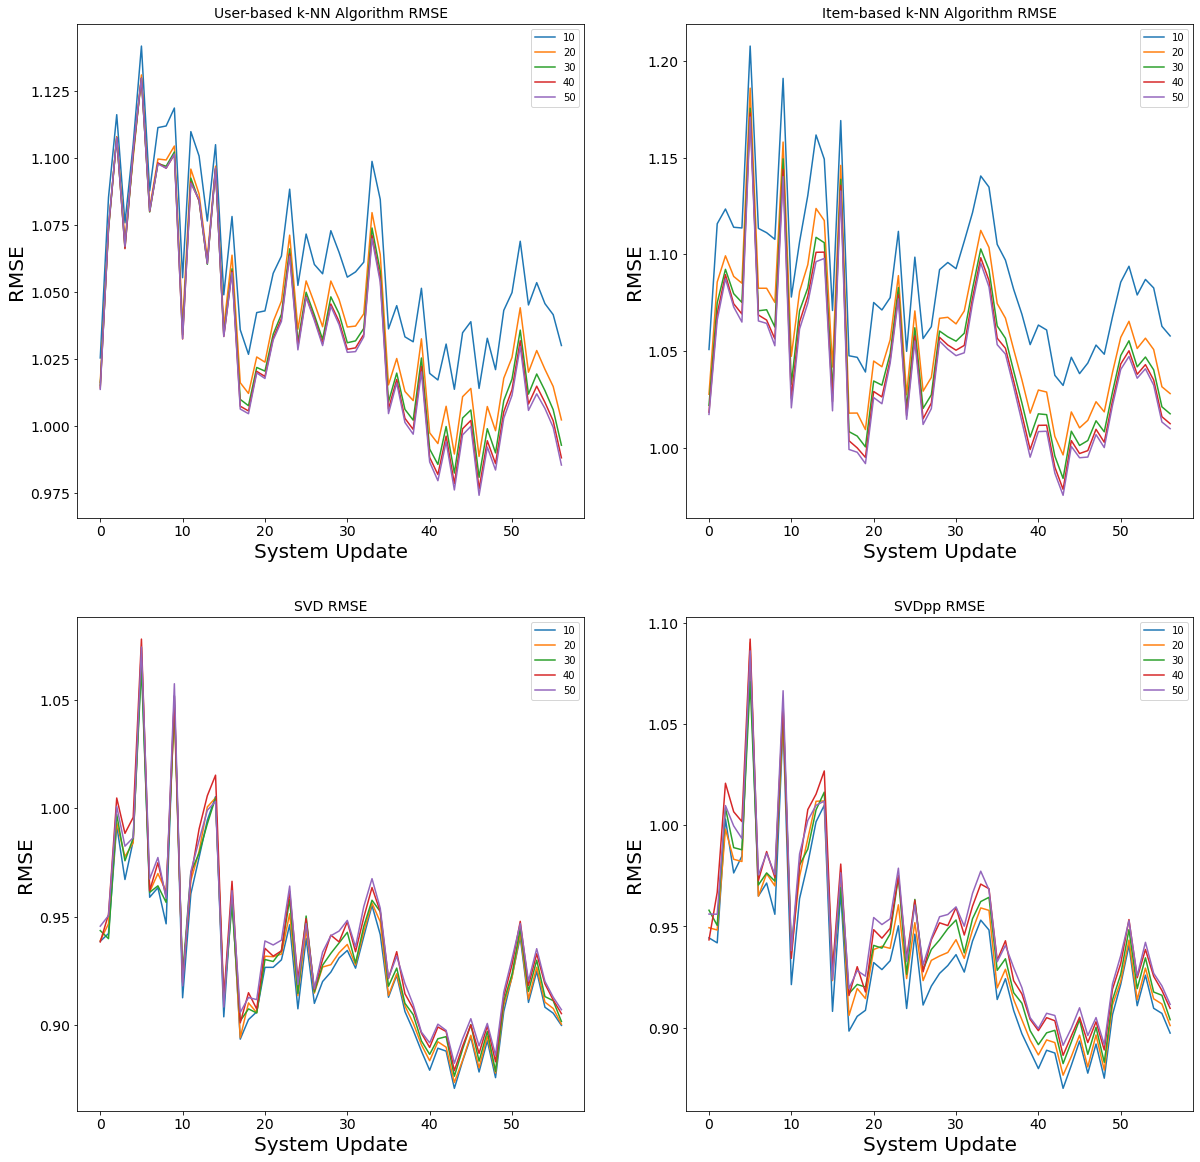

In [0]:
### -------------   Visualize the result based on Algorithm   -------------- ###
fig, ax = plt.subplots(2, 2, figsize = (20,20))
index = 0
for row in range(2):
  for col in range(2):
    result[rmse_name[index]].plot(kind = 'line', ax = ax[row, col])
    ax[row, col].set_ylabel('RMSE')
    ax[row, col].set_title(rmse_name[index])
    ax[row, col].set_xlabel('System Update')
    index += 1

We could observe the sequential results for both neighbourhood methods and latent factor methods as presented above. One of the interesting result to note is for Item-based k-NN algorithms, the higher the number of neighbour, the better the performance at any given system update. On the other hand, the result for $k = 10$ is the highest RMSE, meaning lower performance, at any given system update compares to the result on other number of neighbours in User-based k-NN algorithm. Moreover, the result for SVD algorithm shows that the higher the number of factor to be included in rating calculation negatively impacted the performance, whereas $factor = 10$ outperformed other number of factors in 47 out of 57 system updates. The result for SVD++ algorithm also presents similar pattern where the lower the number of factor, the better the performance for $factor = 10$ outperformed other number of factors in 50 out of 57 system updates. However, there is an exception for SVD++ algorithm where the result for $factor = 40$ (0.9434) in the first update is outperformed the result for any other factors.
<br>
<br>
Furthermore, we identify 14 updates where the performance of all algorithms drop at any given number of neighbour and factor. They are update $[2, 11, 16, 23, 25, 28, 32, 33, 44, 47, 49, 50, 51, 53]$. The most notable drop is on update 16, where the performance drop ranges from $2.31\%$ (User-based k-NN algorithm for $k = 50$) to $11.15\%$ (Item-based k-NN algorithm for $k = 50$). This drop in performance signifies the changes in the rating distribution, considering the changes in majority rating proportion in days 1000 in the dataset from rating 3 to rating 4, around the same time as test set for system update 16.
<br>
<br>
Moreover, we grouped the result by the number of neighbours and the number of factor as follows:

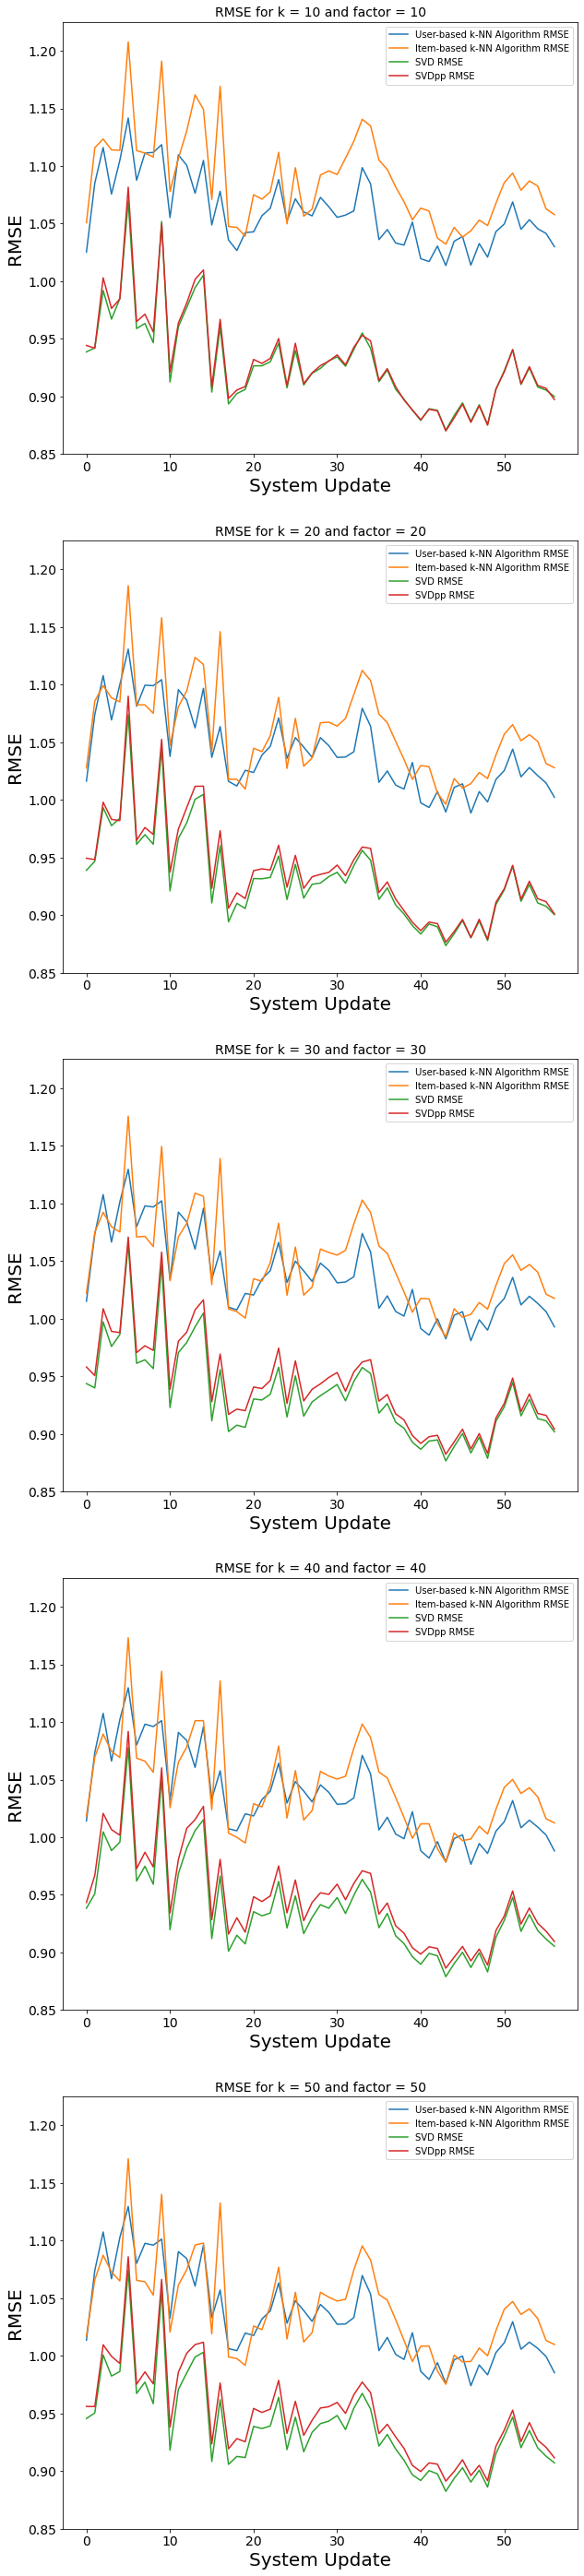

In [0]:
### -------------   Visualize the result based on Parameter   -------------- ###
fig, ax = plt.subplots(5, 1, figsize = (10,50))
factors = [i for i in range(10,60,10)]
for row, factor in enumerate(factors):
  RMSE[factor].plot(kind = 'line', ax = ax[row])
  ax[row].set_ylabel('RMSE')
  ax[row].set_ylim(0.85, 1.225)
  ax[row].set_title('RMSE for k = {} and factor = {}'.format(factor, factor))
  ax[row].set_xlabel('System Update')

Plotting the result based on number of neighbour and number of factor gives graphical illustration of how the parameter changes affect the performance of algorithms. As we could observe, SVD algorithm consistently perform the best across all number of neighbour and factor we try. However, the average distance between the neighbourhood methods and latent factor methods is getting closer as the number of neighbour and factor increases. The detail of these average distance between the two methods is as follows:

Number of k and factor | Average Distance
--- | ---
10 | 0.1438
20 | 0.1153
30 | 0.1047
40 | 0.0962
50 | 0.0932

Furthermore, the closest distance between the two methods happen between User-based k-NN algorithm for $k = 50$ and SVD++ algorithm for $factor = 50$ in update 9 which is 0.0350 difference in RMSE. On the other hand, the furthest distance is happen between Item-based k-NN algorithm for $k = 10$ and SVD algorithm for $factor = 10$ in Update 16 which is 0.2088 difference in RMSE. These details align with our earlier observation that for the neighbourhood methods, the higher the number of neighbour the better the performance, and *vice versa* for the latent factor methods, the higher the number of factor, the lower the performance.
<br>
<br>
Finally, we investigate the range of performance for each algorithm as follows:

In [0]:
### ------------   Helper Function for Summarizing the result   ------------ ###
def get_details(Series):
  value = dict()
  value['Best Performance'] = Series.min()
  value['Best Update'] = int(Series[Series == value['Best Performance']].index.values)
  value['Worst Performance'] = Series.max()
  value['Worst Update'] = int(Series[Series == value['Worst Performance']].index.values)
  value['Average Score'] = Series.mean()
  return value

In [0]:
### ---------------   Present the result to answer the RQ   ---------------- ###
details = dict()
for name in rmse_name:
  for k_factor in k_factors:
    if name != ('SVD RMSE' or 'SVDpp RMSE'):
      details[tuple((name, k_factor))] = get_details(result[name][k_factor])
    else: details[tuple((name, k_factor))] = get_details(result[name][k_factor])

details = pd.DataFrame.from_dict(details)
details.columns = pd.MultiIndex.from_tuples(details.columns, names=['Algorithm','Neighbour or Factor'])
details = details.T
details['Best Update'] = details['Best Update'].astype(int)
details['Worst Update'] = details['Worst Update'].astype(int)
display(details)

Best Performance  ...  Average Score
Algorithm                      Neighbour or Factor                    ...               
User-based k-NN Algorithm RMSE 10                           1.013668  ...       1.060349
                               20                           0.988637  ...       1.042215
                               30                           0.980856  ...       1.037046
                               40                           0.976544  ...       1.034836
                               50                           0.974144  ...       1.033721
Item-based k-NN Algorithm RMSE 10                           1.032242  ...       1.089179
                               20                           0.996289  ...       1.059839
                               30                           0.984147  ...       1.049702
                               40                           0.978502  ...       1.044751
                               50                           0.975404  ...       1.041788
SVD RMSE                       10                           0.870919  ...       0.929709
                               20                           0.873606  ...       0.932789
                               30                           0.876503  ...       0.934222
                               40                           0.879043  ...       0.938393
                               50                           0.882465  ...       0.939175
SVDpp RMSE                     10                           0.870121  ...       0.932187
                               20                           0.876593  ...       0.938662
                               30                           0.882328  ...       0.943096
                               40                           0.886400  ...       0.948685
                               50                           0.891353  ...       0.949752

[20 rows x 5 columns]

From the table above, we can observe that the performance CF algorithms lies on a range of values, as noted by Lathia (2010). Moreover, the range of performance for an algorithm depends on the number of neighbour and factor being selected. In general, for number of neighbours $[10, 20, 30, 40, 50]$, the prediction error of neighbourhood methods lies on the range of $[0.9741, 1.2077]$, with the range of prediction error for User-based *k*-NN algorithm lies on the range of $[0.9741, 1.1416]$ and the prediction error for Item-based *k*-NN algorithm lies on the range of $[0.9754, 1.2077]$. Whilst the worst performance of this methods happen in Update 5 for all number of neighbours, the best performance for Item-based *k*-NN algorithm in all number of neighbour and User-based *k*-NN algorithm for $k = 10$ happen on the update 43. On the other hand, the lowest prediction error of other number of neighbour in User-based *k*-NN algorithm happen on update 46. Furthermore, for number of factor $[10, 20, 30, 40, 50]$, the prediction error of latent factor models lies on the range of $[0.8701, 1.0918]$, with the prediction error for SVD algorithm lies on the range of $[0.8709, 1.0779]$ and the prediction error for SVD++ algorithm lies on the range of $[0.8701, 1.0918]$. Whilst the lowest RMSE for both algorithms happen at update 43, their worst performance happen at update 5.

It is important to note that we do not find any evidence that the neighbourhood methods outperformed the latent factor models, neither at any given system update, nor at any number of neighbour and number of factor. It is different from what Lathia (2010) highlights that the performance of Item-based *k*-NN algorithm overlap with SVD algorithm. We understand this due to the differences in update interval in this research, sampling methods, and number of factor selected for the SVD algorithm. Therefore, the result of this research confirms the claim made by Koren and Bell (2015) that latent factor models perform better than the neighbourhood methods. However, we do found that SVD++ algorithm does not always perform better than SVD algorithm as suggested by Koren and Bell (2015), even using the same number of factor for both algorithms. In fact, we found that the temporal performance of SVD algorithm is better than SVD++ algorithm for all $factor \neq 10$. This contradiction is highlighted by Lathia (2010) that it is challenging to claim one algorithm outperformed the others when only a static case is investigated. Therefore, how an algorithm perform over time should always be investigated before claiming its superiority over other algorithms.

---

## 4.2 Time-averaged Result

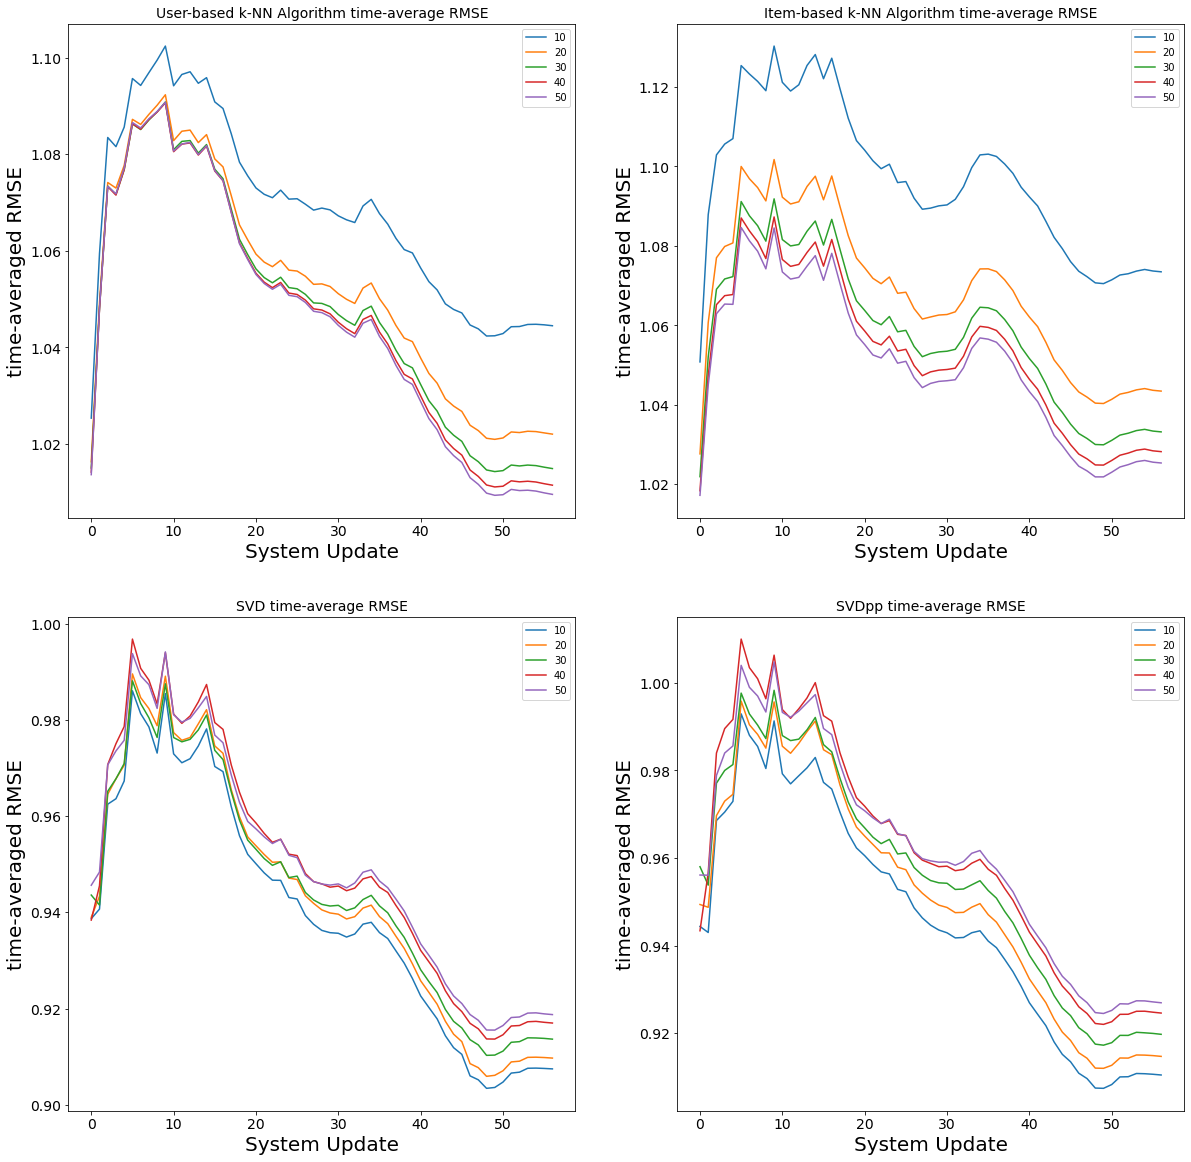

In [0]:
### -------------   Visualize the result based on Algorithm   -------------- ###
fig, ax = plt.subplots(2, 2, figsize = (20,20))
index = 0
for row in range(2):
  for col in range(2):
    result[time_rmse_name[index]].plot(kind = 'line', ax = ax[row, col])
    ax[row, col].set_ylabel('time-averaged RMSE')
    ax[row, col].set_title(time_rmse_name[index])
    ax[row, col].set_xlabel('System Update')
    index += 1

The movement of the time-average RMSE means the changes on \emph{quality} of the training set in which the algorithms are trained upon. Similar to the sequential result, time-averaged result also present the same pattern that, for neighbourhood methods, the higher the number of neighbour, the better the performance, and \emph{vice versa}, for the latent factor models, the higher the number of factor, the worse the performance. Moreover, we also observe 9 updates $[2, 9, 12, 14, 33, 34, 50, 51, 53]$ in which the time-averaged RMSE of all algorithms simultaneously falls at any given number of neighbour and number of factor. The most notable fall happens on update 9, where the performance drop ranging from $1.38\%$ (Item-based k-NN algorithm for $k = 10$) to $2.85\%$ (SVD++ algorithm for $factor = 40$). In general, all algorithms present converge trend towards better performance as the training set expand.
<br>
<br>
Furthermore, we also grouped time-averaged RMSE by the number of neighbours and the number of factor as follows:


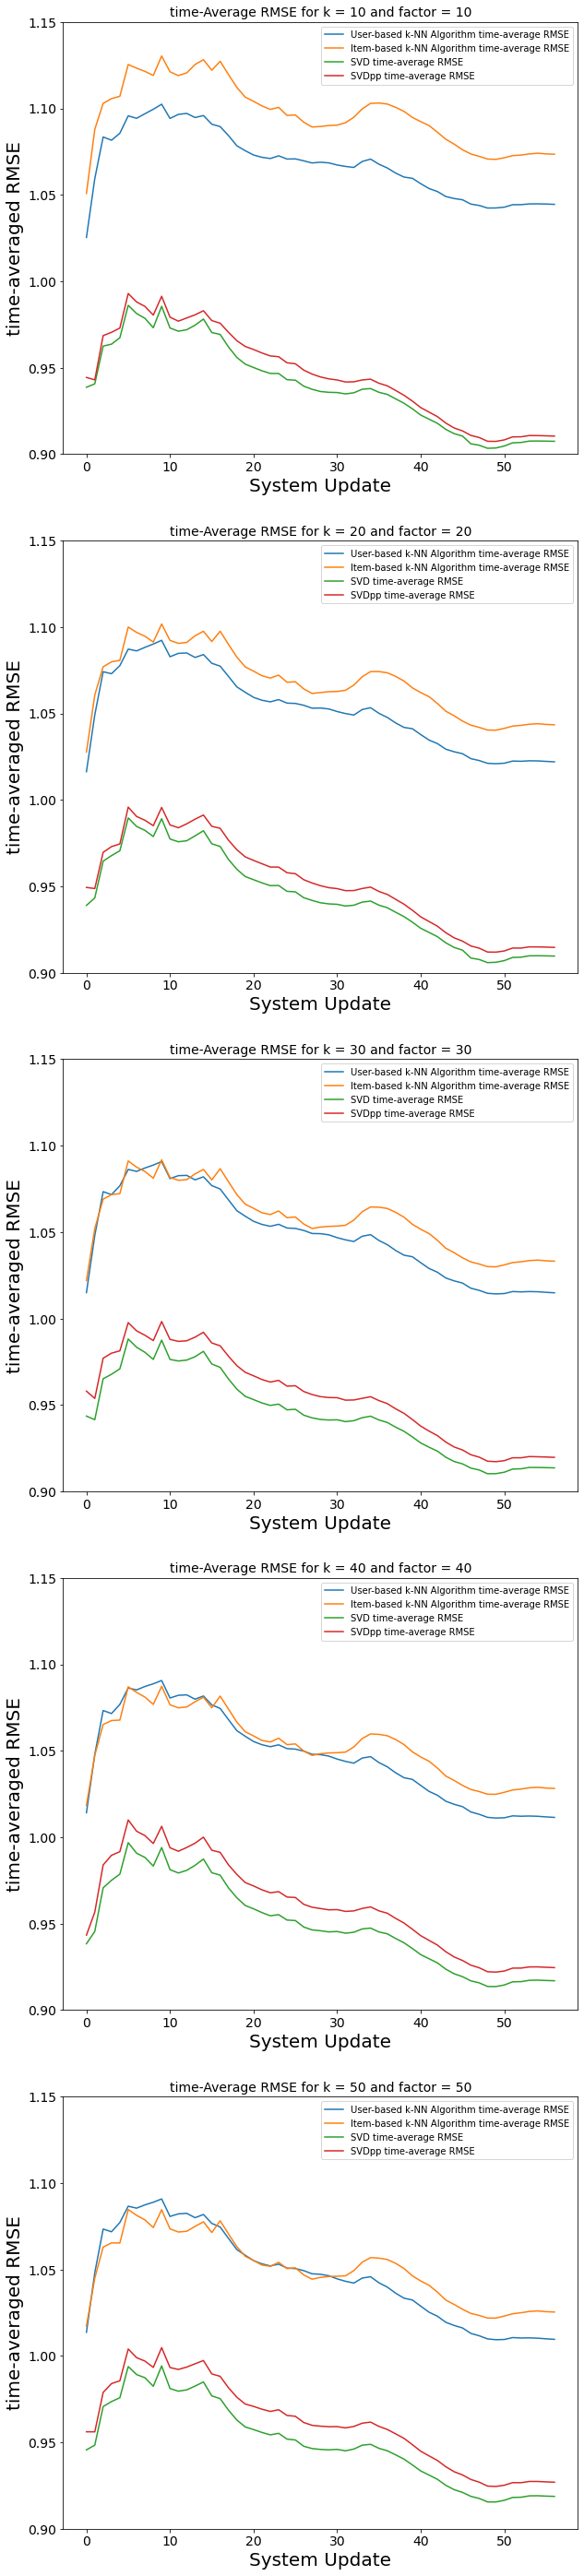

In [0]:
### -------------   Visualize the result based on Parameter   -------------- ###
fig, ax = plt.subplots(5, 1, figsize = (10,50))
factors = [i for i in range(10,60,10)]
for row, factor in enumerate(factors):
  time_RMSE[factor].plot(kind = 'line', ax = ax[row])
  ax[row].set_ylabel('time-averaged RMSE')
  ax[row].set_ylim(0.9, 1.15)
  ax[row].set_title('time-Average RMSE for k = {} and factor = {}'.format(factor, factor))
  ax[row].set_xlabel('System Update')

Similar to sequential result --- we found no evidence that the performance of neighbourhood methods overlap with the performance of latent factor models, at any given system update and number of neighbour and number of factor --- in time-averaged result. One interesting observation we could make is that the difference between the two methods, on all number of neighbour and number of factor, reach its lowest point on the first update. The closest difference of performance happen also between User-based k-NN algorithm for $k = 30$ and SVD++ algorithm for $factor = 30$ with $0.0570$ difference in time-averaged RMSE on the first update. The furthest distance, on the other hand, also happen between Item-based k-NN algorithm for $k = 10$ and SVD algorithm for $factor = 10$ with $0.1698$ difference in time-averaged RMSE on update 41.
<br>
<br>
Finally, we investigate the range of time-averaged RMSE for each algorithm as follows:

In [0]:
### ---------------   Present the result to answer the RQ   ---------------- ###
details = dict()
for name in time_rmse_name:
  for k_factor in k_factors:
    if name != ('SVD RMSE' or 'SVDpp RMSE'):
      details[tuple((name, k_factor))] = get_details(result[name][k_factor])
    else: details[tuple((name, k_factor))] = get_details(result[name][k_factor])

details = pd.DataFrame.from_dict(details)
details.columns = pd.MultiIndex.from_tuples(details.columns, names=['Algorithm','Neighbour or Factor'])
details = details.T
details['Best Update'] = details['Best Update'].astype(int)
details['Worst Update'] = details['Worst Update'].astype(int)
display(details)

Best Performance  ...  Average Score
Algorithm                                   Neighbour or Factor                    ...               
User-based k-NN Algorithm time-average RMSE 10                           1.025352  ...       1.067915
                                            20                           1.016319  ...       1.052301
                                            30                           1.014282  ...       1.048272
                                            40                           1.011100  ...       1.046716
                                            50                           1.009366  ...       1.046025
Item-based k-NN Algorithm time-average RMSE 10                           1.050816  ...       1.096812
                                            20                           1.027670  ...       1.067970
                                            30                           1.021932  ...       1.057999
                                            40                           1.018394  ...       1.053126
                                            50                           1.017241  ...       1.050170
SVD time-average RMSE                       10                           0.903396  ...       0.940099
                                            20                           0.905896  ...       0.943460
                                            30                           0.910258  ...       0.944715
                                            40                           0.913643  ...       0.949239
                                            50                           0.915513  ...       0.949609
SVDpp time-average RMSE                     10                           0.907393  ...       0.946117
                                            20                           0.911963  ...       0.951213
                                            30                           0.917248  ...       0.955387
                                            40                           0.921999  ...       0.960688
                                            50                           0.924491  ...       0.960975

[20 rows x 5 columns]

We could observe from table above that the best and the worst performance for each algorithm and each hyper-parameter happen at different system update. The best performance for User-based k-NN algorithm for $k = [10, 20]$ happens in the first update, and for the rest of the tested $k$, it happens at update 49. On the other hand, the worst performance for SVD algorithm for $k \neq 50$ happens on update 5, and for $k = 50$, it happens later on update 9. This indicate how the hyper-parameter setting inside the algorithm cope with difference in quality of training data, an interesting topic we plan to address in the future research. 

# 5. Discussion

In this work, we focus on investigating the performance of CF algorithms when evaluated using temporal settings. We aim provide better understanding about the performance drift when CF algorithms are deployed in production stage, thus help the businesses to design and/or improve their existing RS to provide better recommendation to the customer. Indeed, better recommendation will reduce our exposure to information overload and, on a greater extent, improve our overall quality of life. In doing so, we evaluate 4 CF algorithms that belongs to 2 main disciplines of CF: the neighbourhood methods (User-based and Item-based k-NN algorithms) and the latent factor models (SVD and SVD++ algorithms). \par

Considering the sequential result and the time-averaged result, we found that the prediction error for User-based \textit{k}-NN algorithm lies $[0.9741, 1.1416]$ and the prediction error for Item-based \textit{k}-NN algorithm lies on the range of $[0.9754, 1.2077]$. Moreover, we also found that the prediction error for SVD algorithm lies on the range of $[0.8709, 1.0779]$ and the prediction error for SVD++ algorithm lies on the range of $[0.8701, 1.0918]$. Whilst Lathia (2010) suggests that performance of the neighbourhood methods depend on proper value of $k$ being selected, we found that it tends to get better as higher number of neighbour increase. Moreover, we found that the performance of latent factor models decrease as number of factor increases. However, we found no evidence that these performance overlap with the latent factor models, at any given system update, using any given hyper-parameter setting we tested. Although it is contrary to what found in Lathia (2010), the authors uses $[20, 35, 50]$ as number of neighbour and 65 as number of factor for SVD algorithm. Thus, as the performance pattern suggests, it makes sense if at one point, the performance of SVD and User-based \textit{k}-NN will overlap with each others. \par

Furthermore, we observe performance overlap between latent factor models. In this sense, SVD++ algorithm does not always perform better than SVD algorithm as suggested by Koren and Bell (2015), even using the same number of factor for both algorithms. In fact, we found that the temporal performance of SVD algorithm is better than SVD++ algorithm for all $factor \neq 10$. We understand this phenomena as the effect of our choice on learning rate, regulatization parameter, and number of epochs. SVD and SVD++ algorithms infer movie and user characteristics via stochastic gradient descend. They first initialize random value as many as the number of factor being included, and adjusted the value based on learning rate parameter and regularization, for as often as number of epochs. Although we follow the learning rate, regularization parameter and number of epochs as suggested in Koren and Bell (2015), different structure of data require different optimum hyper-parameter setting. The process of tuning hyper-parameter setting usually happen in the validation process. However, since we aim to study how these algorithms' performances change over time, and not deciding which algorithm perform the best, we do not perform validation process. We consider our hyper-parameter setting to be justifiable, given we follow the settings of the authors who claim performance superiority. \par

Insights from this work are not observed when performing static evaluation technique. Indeed, the work of Lathia (2010), Soto (2011) and Beel (2017) suggest that performance evaluation over time should always be calculated and presented to better understand the behaviour of CF algorithms. Thus, we echo the message from these authors to always evaluate algorithm's performance in temporal settings before claiming one algorithm is better than the others. Because, the performance of an algorithm depends on which snapshot of data it is trained and evaluated upon and the hyper-parameter settings. Moreover, this work is contribute to the RS literature by performing 3 widely discussed algorithms, namely (1) User-based k-NN, (2) Item-based k-NN and (3) SVD algorithms. We incorporate SVD++ algorithm since it is the least discussed algorithm in time-aware evaluation setting. However, we are aware that all algorithms we evaluate in this work are not incorporating time-information explicitly in the model. We plan to incorporate these algorithms in the future work.

#6. Summary

This work evaluate temporal performance of CF algorithms by incorporating a sequence of training and evaluation process on expanding and dynamic dataset. The performance of all algorithms we evaluate in this research lies on a range of values. For number of neighbours $[10, 20, 30, 40, 50]$, the performance for User-based k-NN algorithm lies on the range of $[0.9741, 1.1416]$ and the performance for Item-based k-NN algorithm lies on the range of $[0.9754, 1.2077]$. On the other hand, for number of factor $[10, 20, 30, 40, 50]$, the performance for SVD algorithm lies on the range of $[0.8709, 1.0779]$ and the performance for SVD++ algorithm lies on the range of $[0.8701, 1.0918]$.

This work indicates the urge to always perform temporal performance evaluation before claiming one algorithm is better than the others. Moreover, future research could work on investigating other performance superiority over other algorithms on temporal settings. Particularly, how continuous time-aware algorithms (e.g. time-weight decay algorithm in \namecite{ding2005time}) perform over time. Indeed, understanding how RS algorithm perform over time help the businesses to design and/or improve their existing RS to provide better recommendation to the customer, thus reduce our exposure to information overload and, on a greater extent, improve our overall quality of life.